### Import Libraries


In [1]:
import pathlib
import sys

from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sys.path.append("../utils")
from split_utils import get_features_data

### Load Labeled Data


In [2]:
# load labeled data
labeled_data_path = pathlib.Path("../0.download_data/data/labeled_data.csv.gz")
labeled_data = get_features_data(labeled_data_path)
# labeled_data

### Create multi class model interpretation figures


Interpreting model: final 
Trained with features: CP
Shape of model coefficients(157, 15)


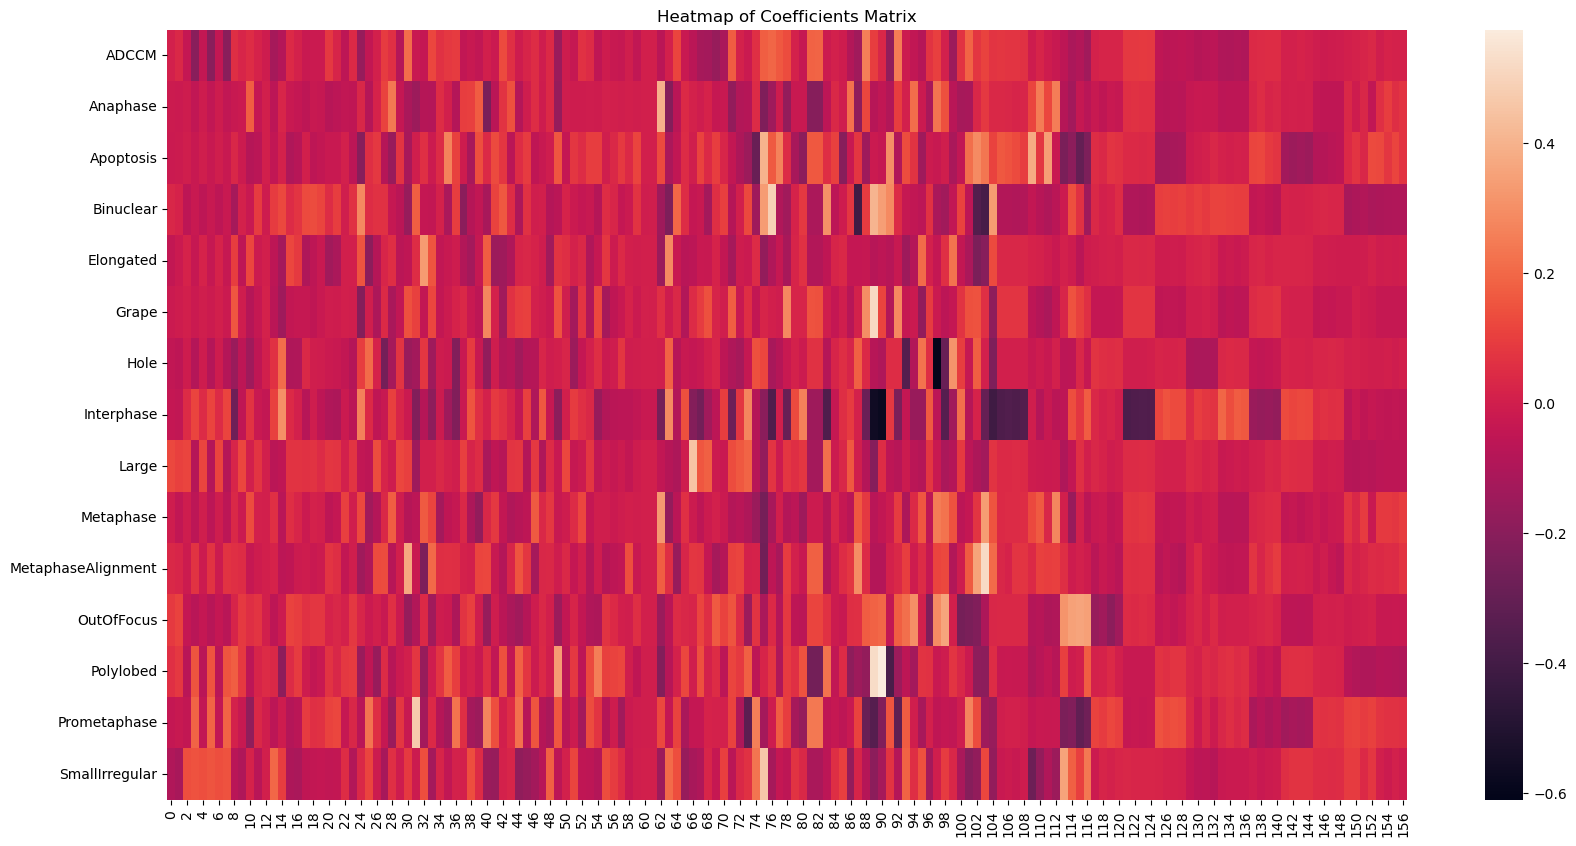

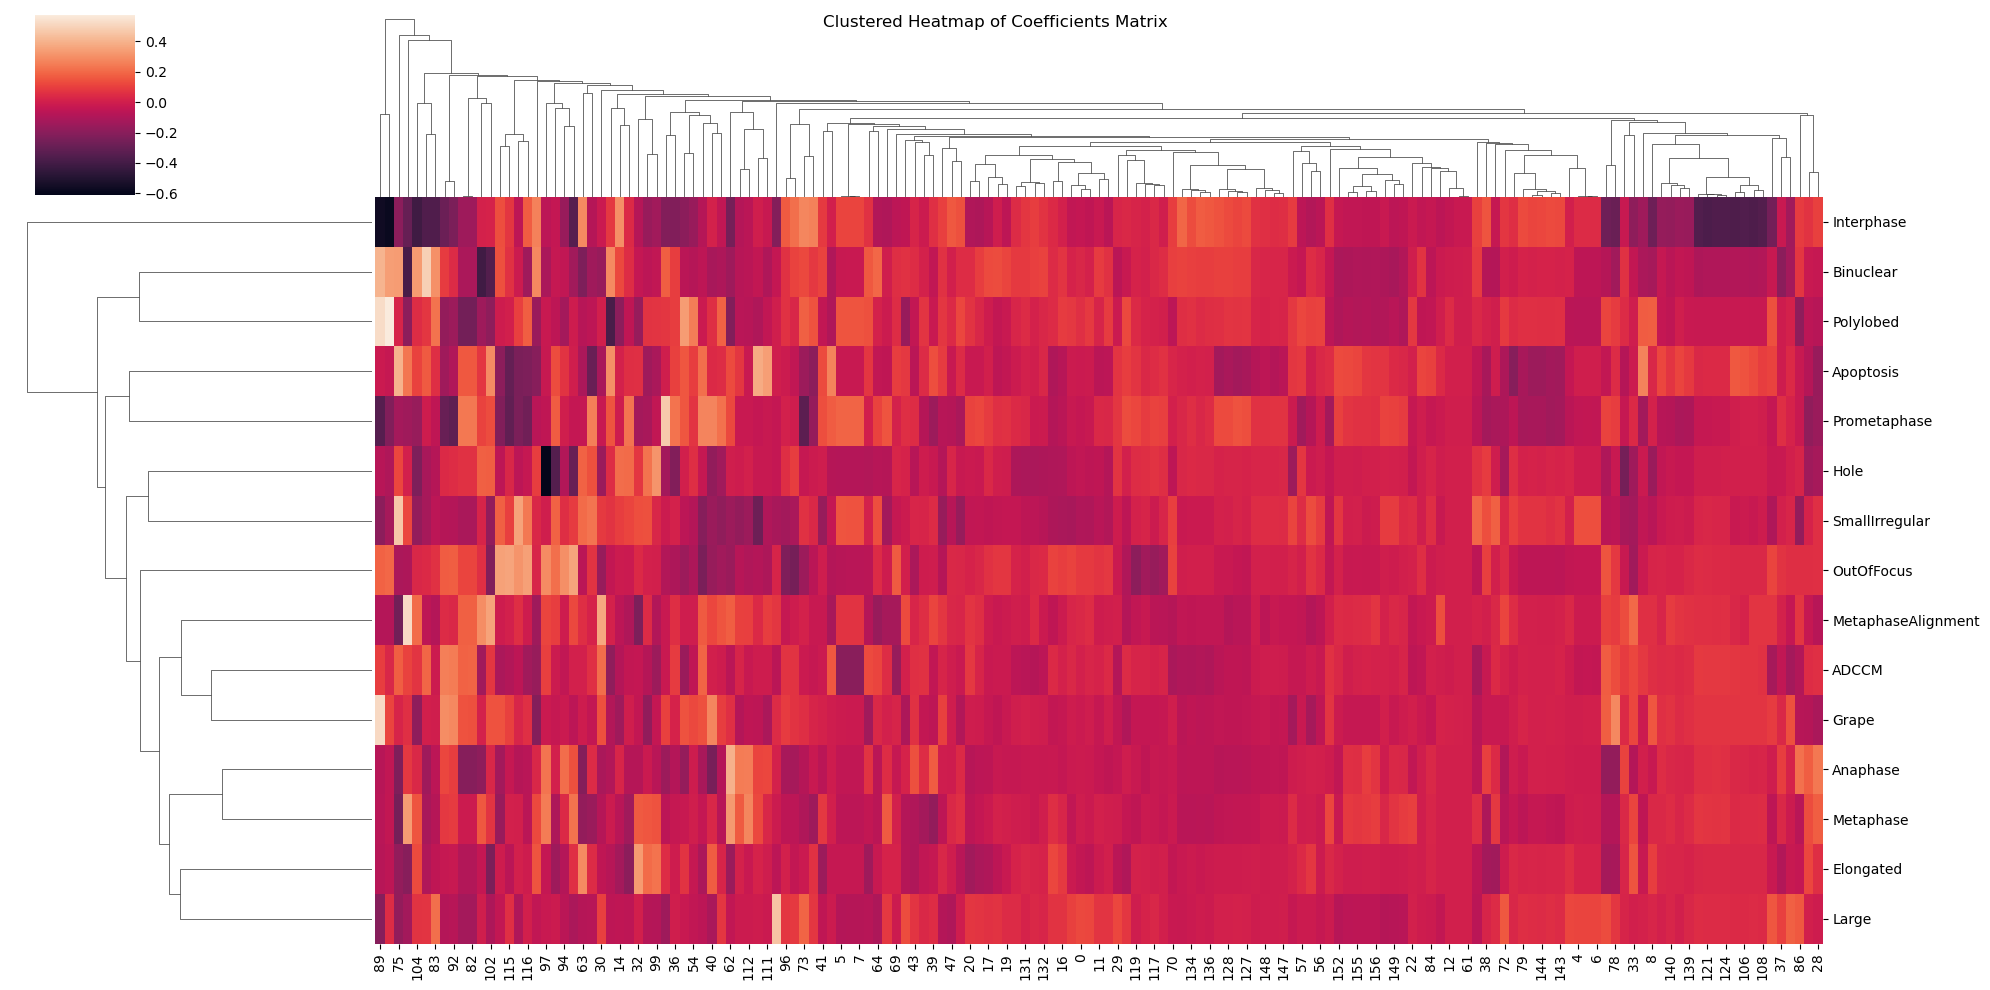

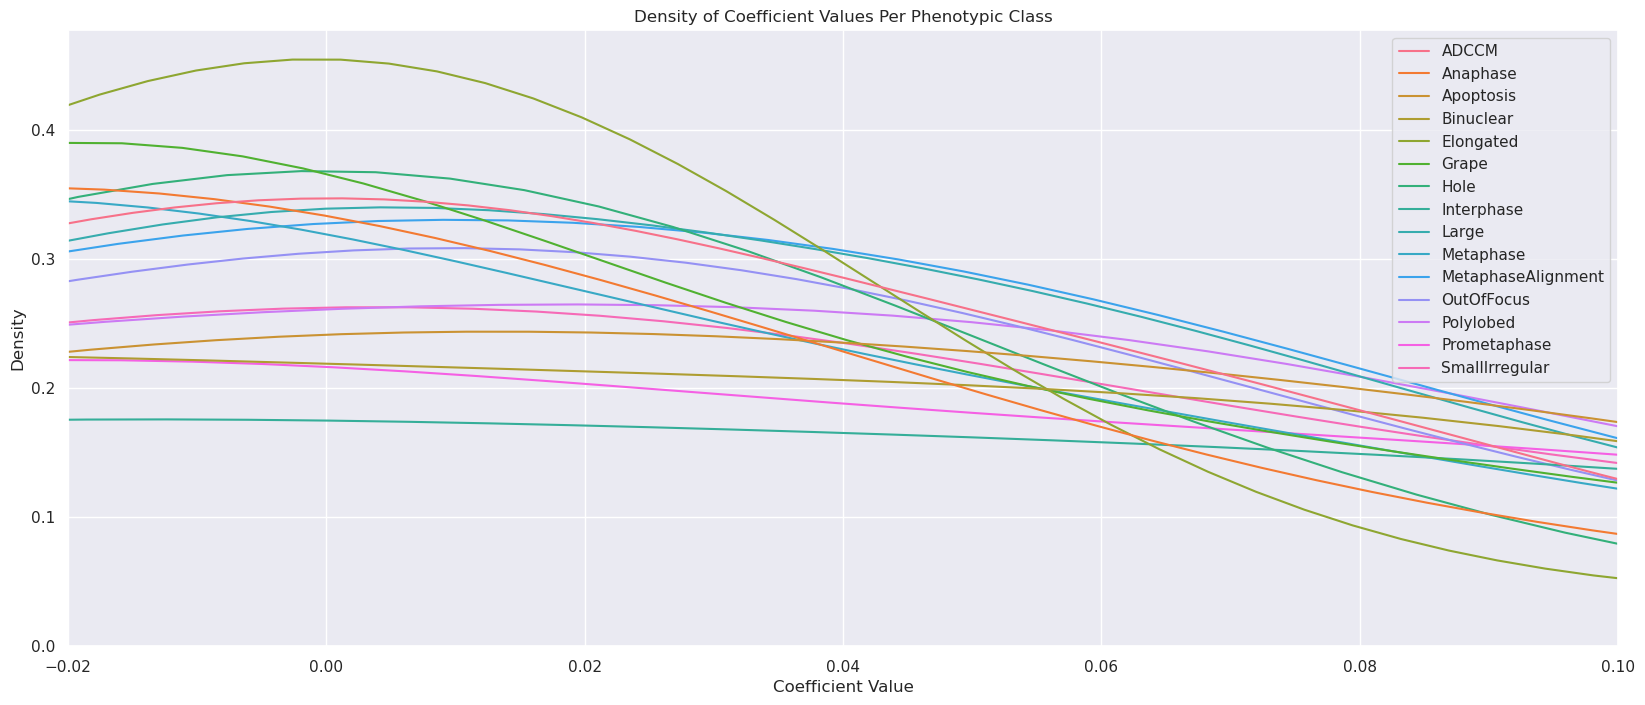

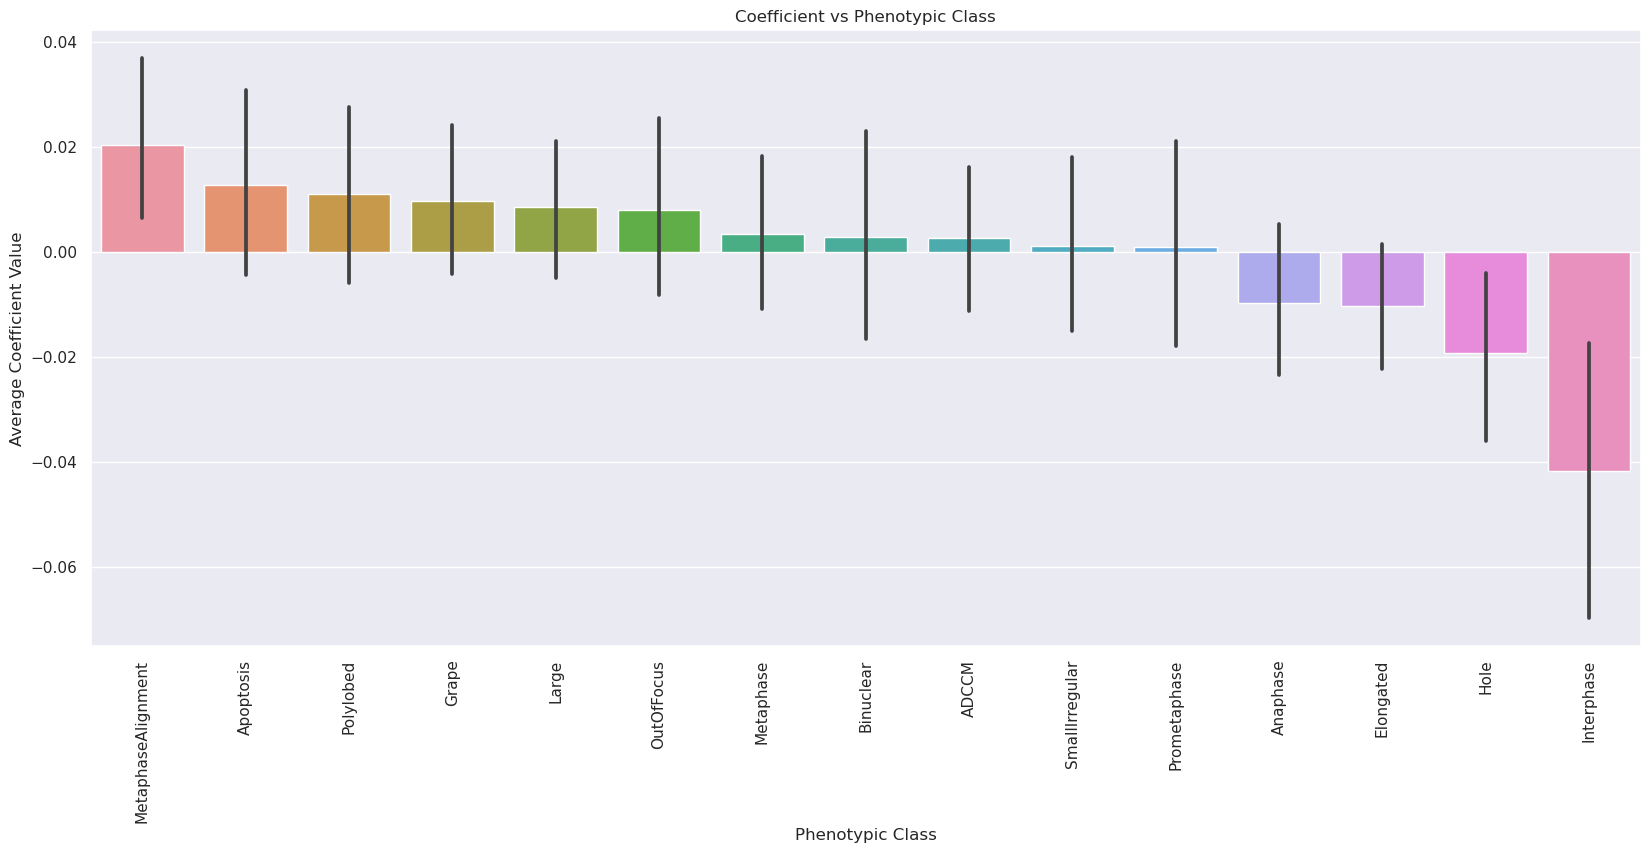

Interpreting model: final 
Trained with features: CP_and_DP
Shape of model coefficients(1437, 15)


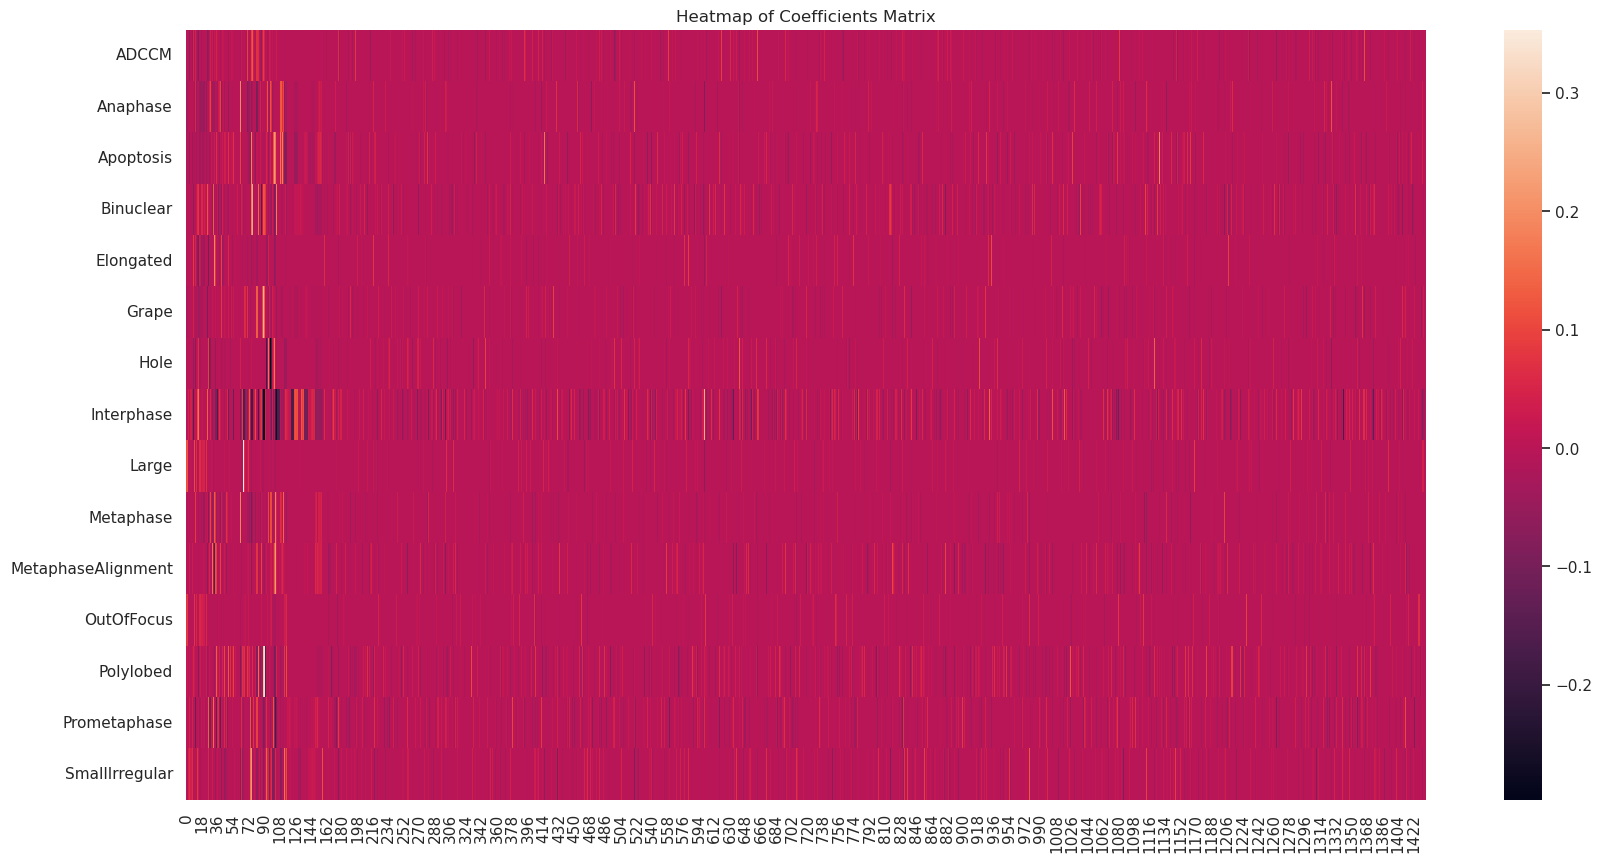

/home/roshankern/anaconda3/envs/phenotypic_profiling/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


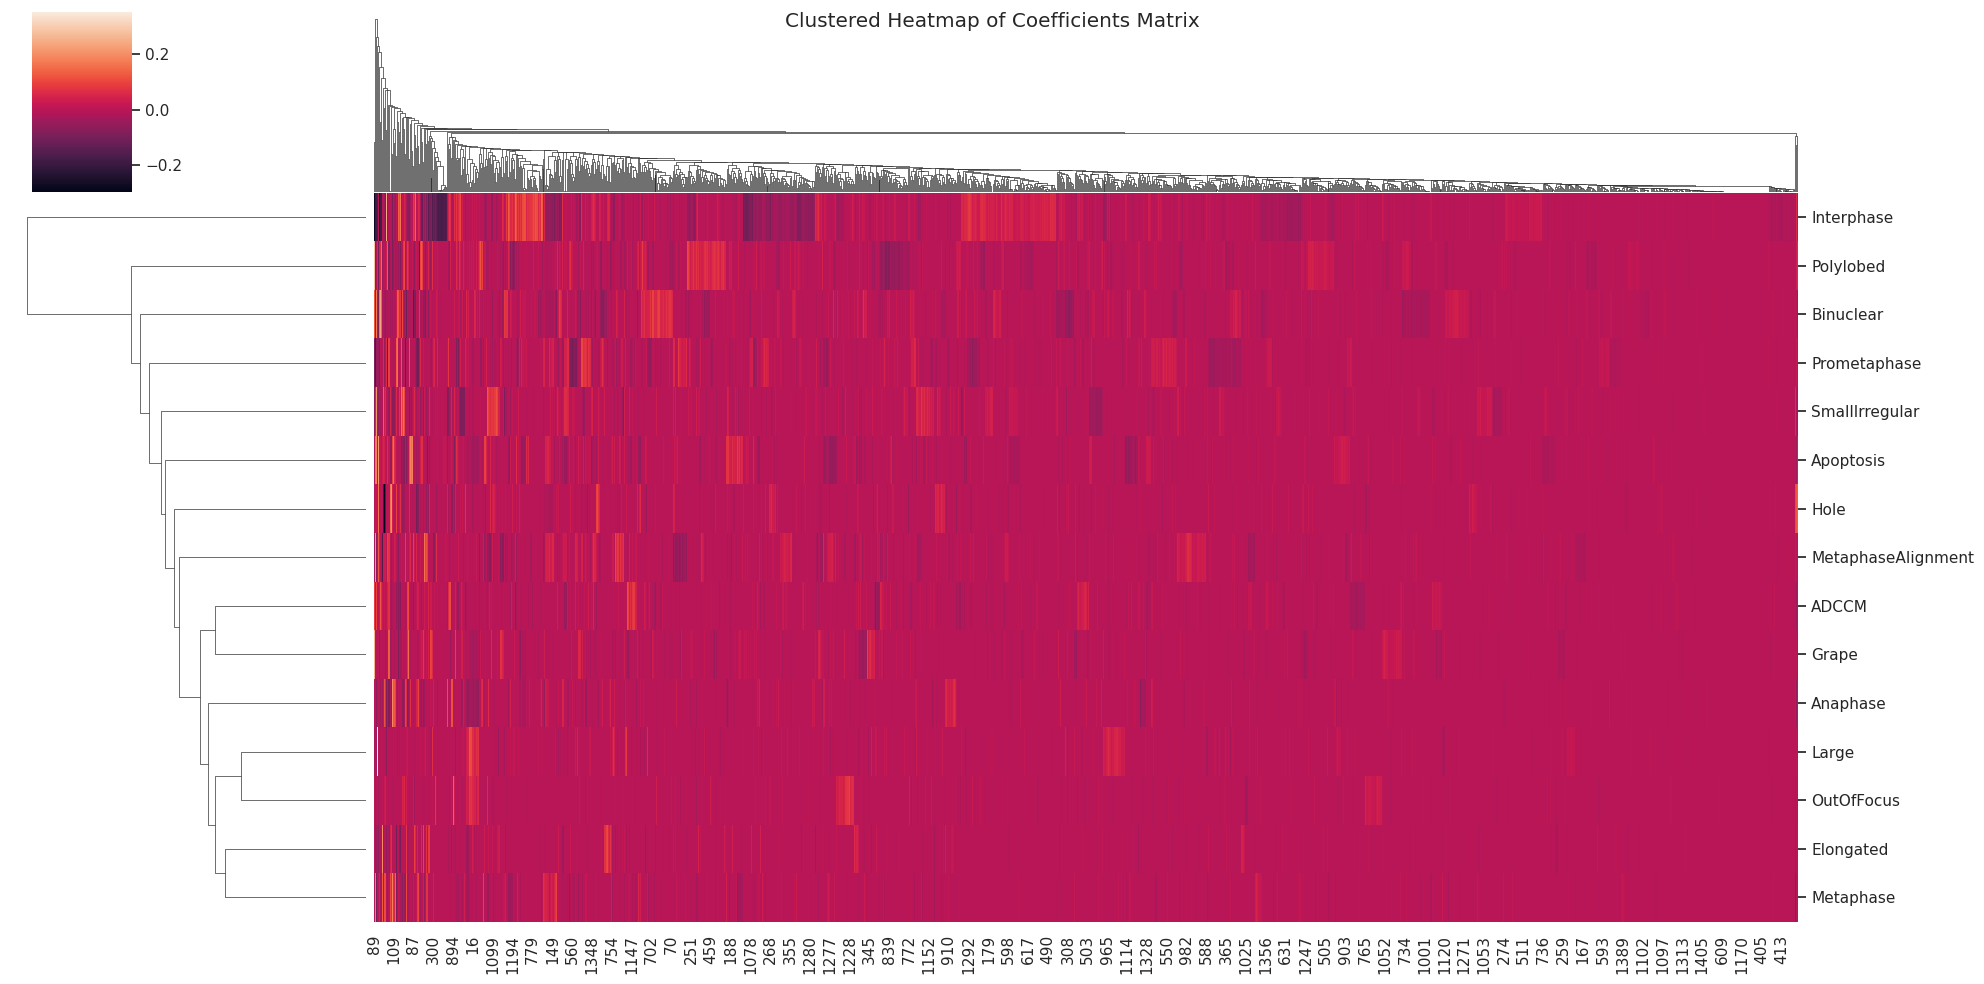

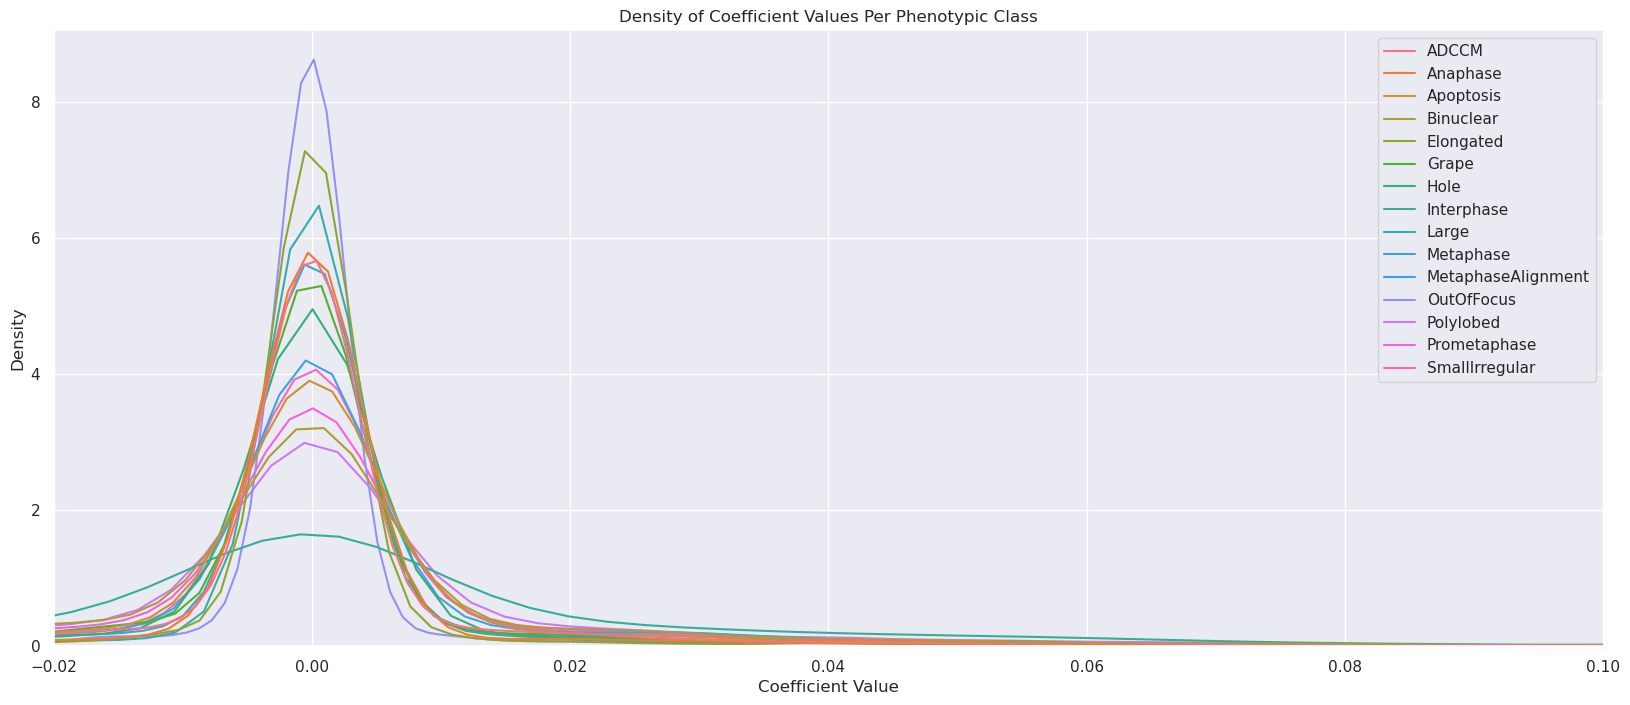

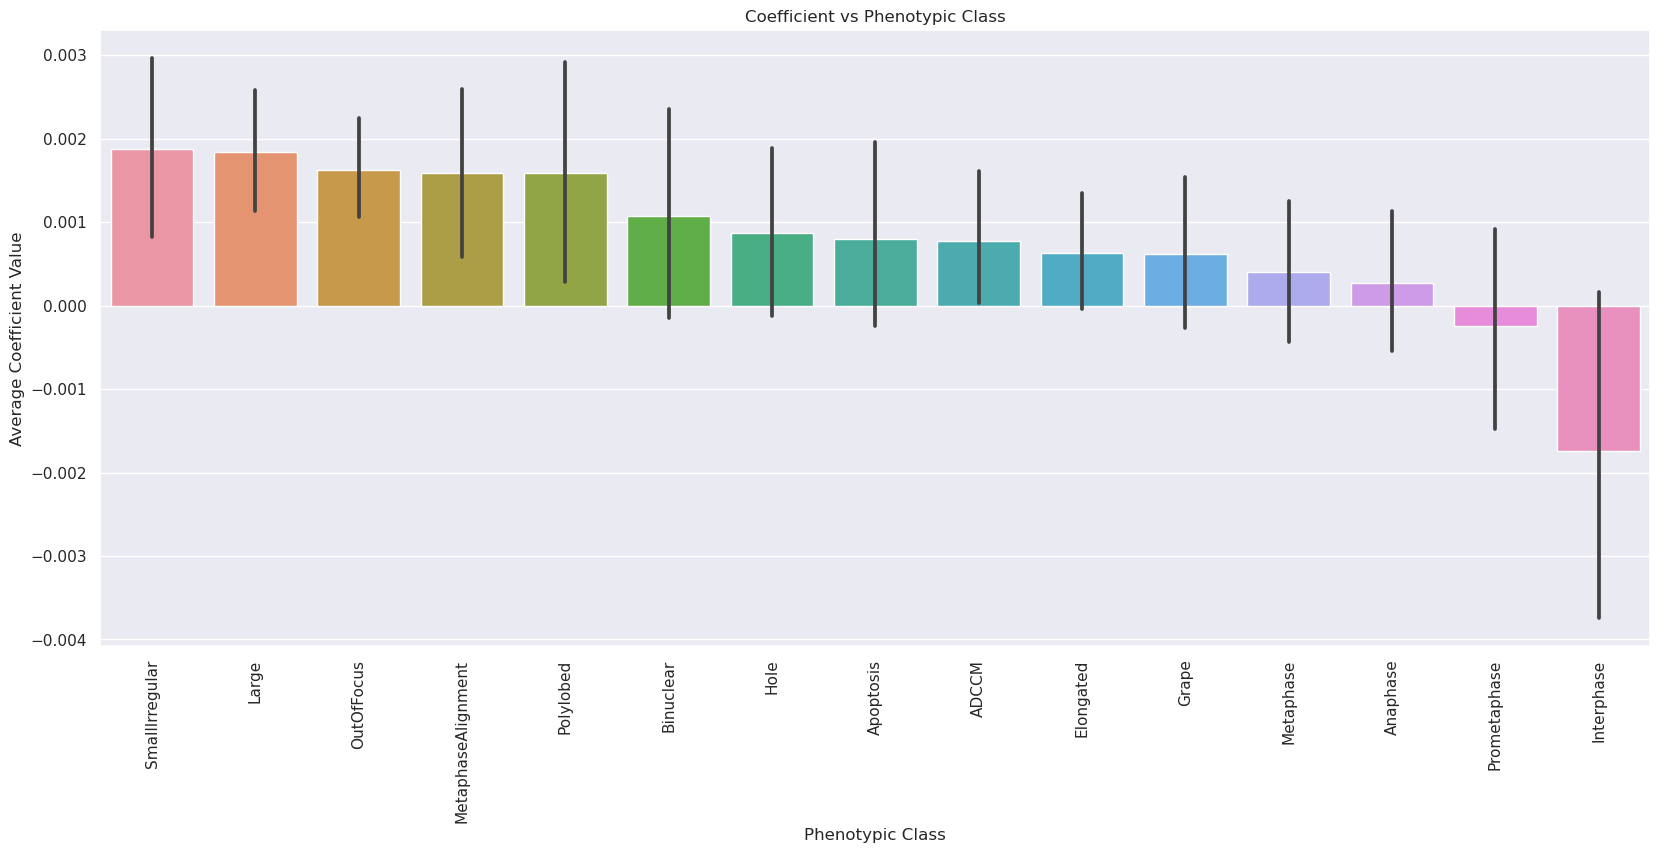

Interpreting model: final 
Trained with features: DP
Shape of model coefficients(1280, 15)


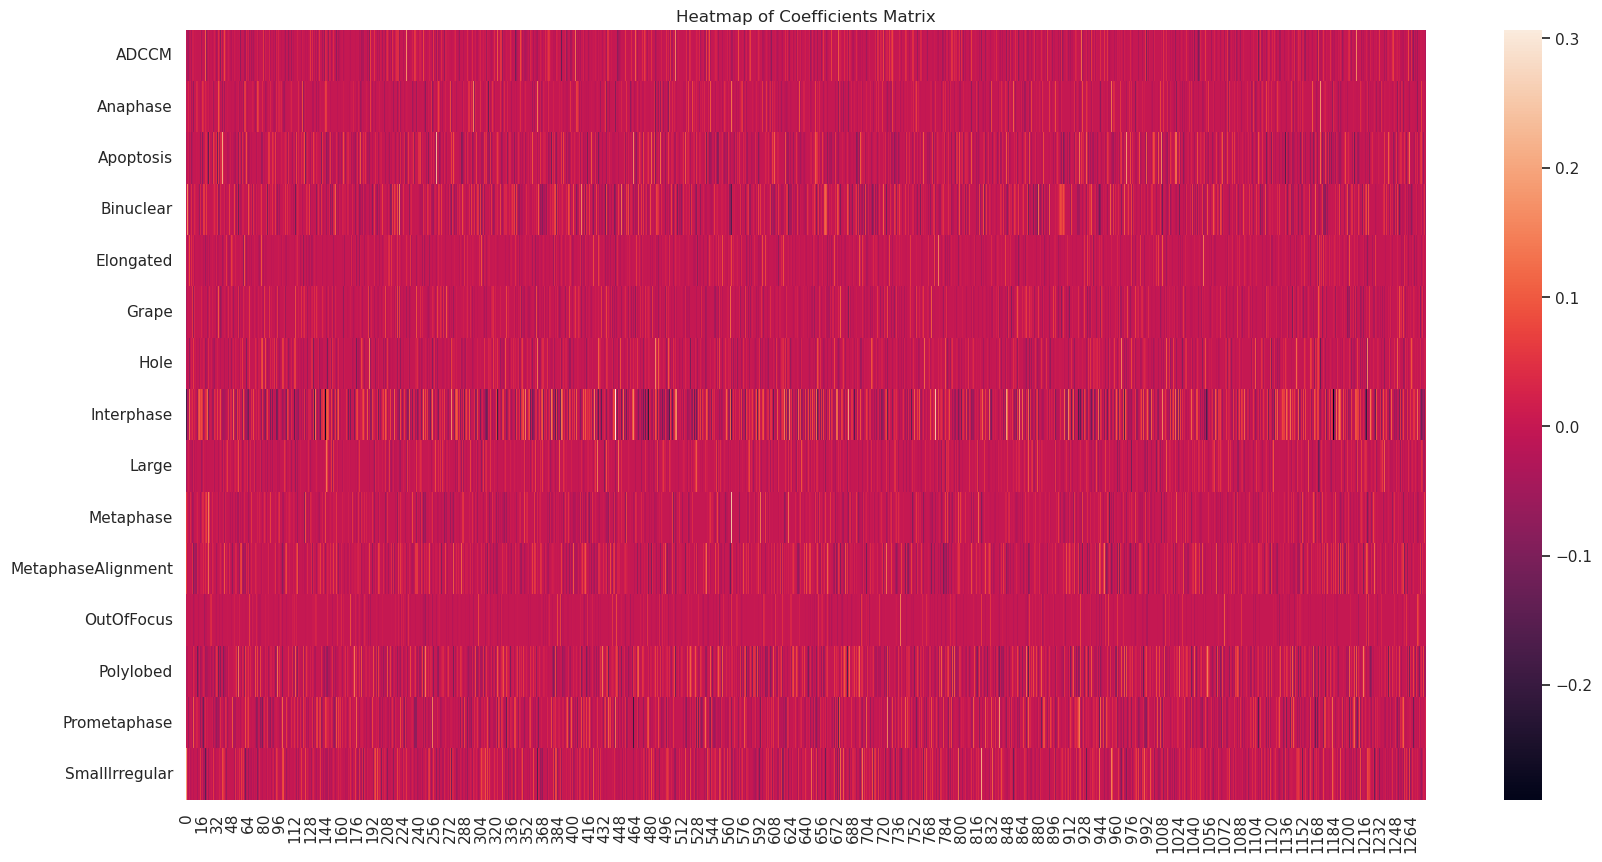

/home/roshankern/anaconda3/envs/phenotypic_profiling/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


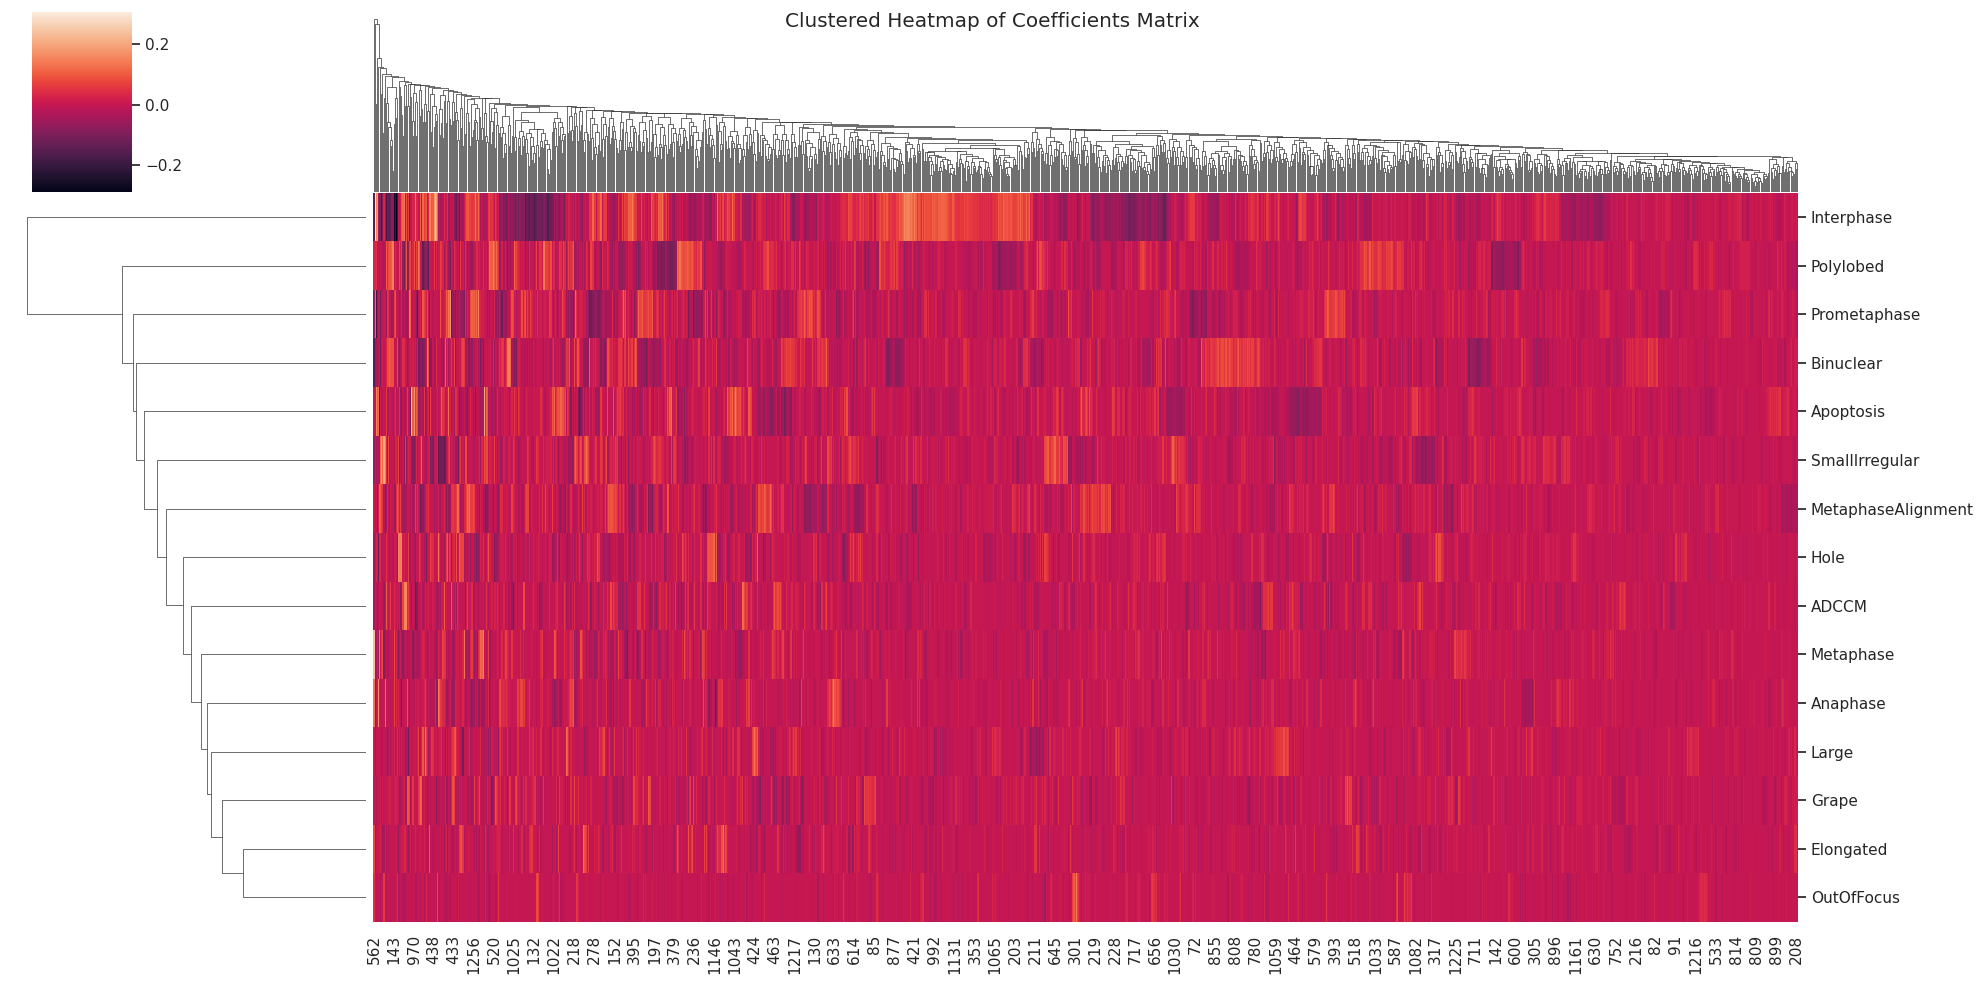

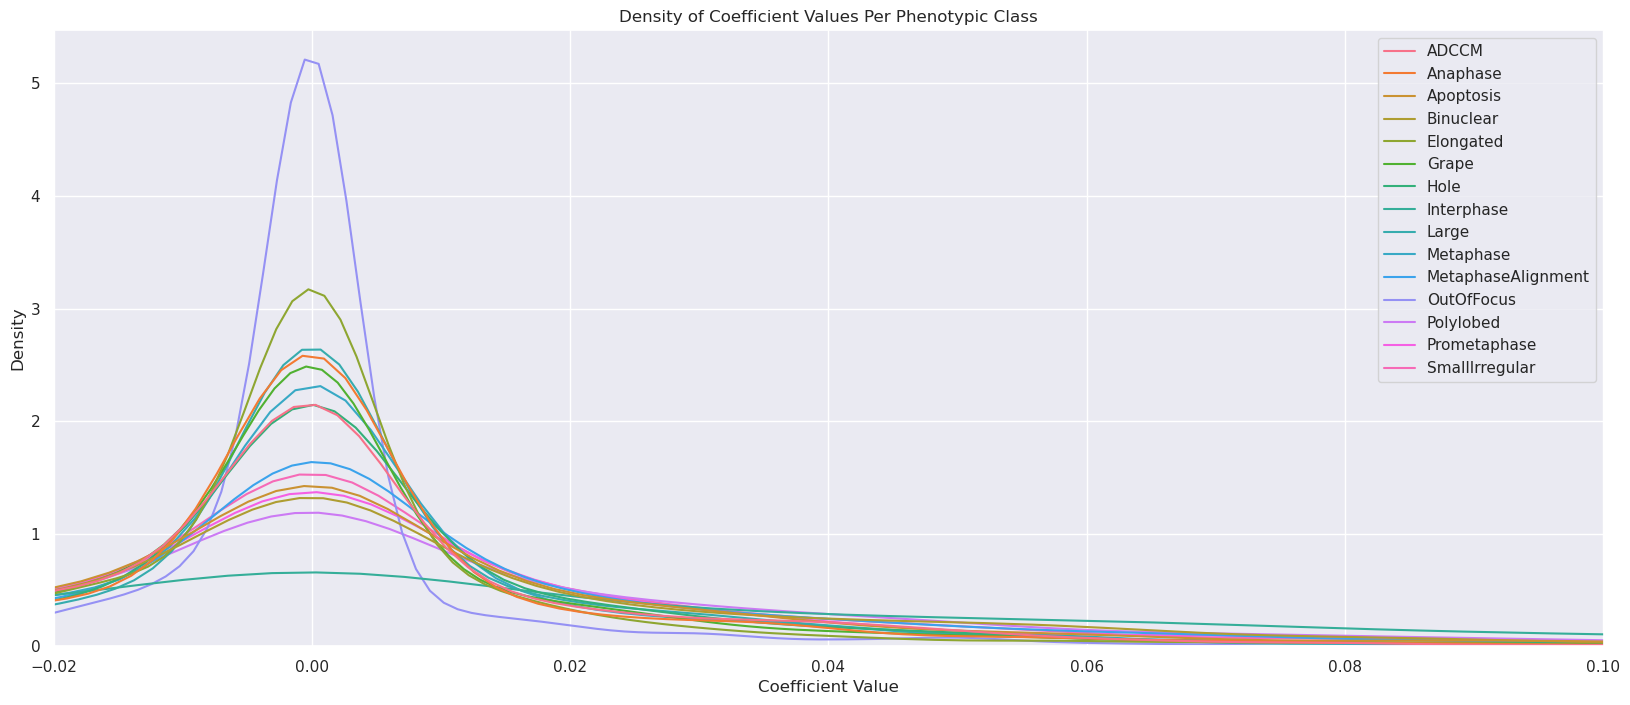

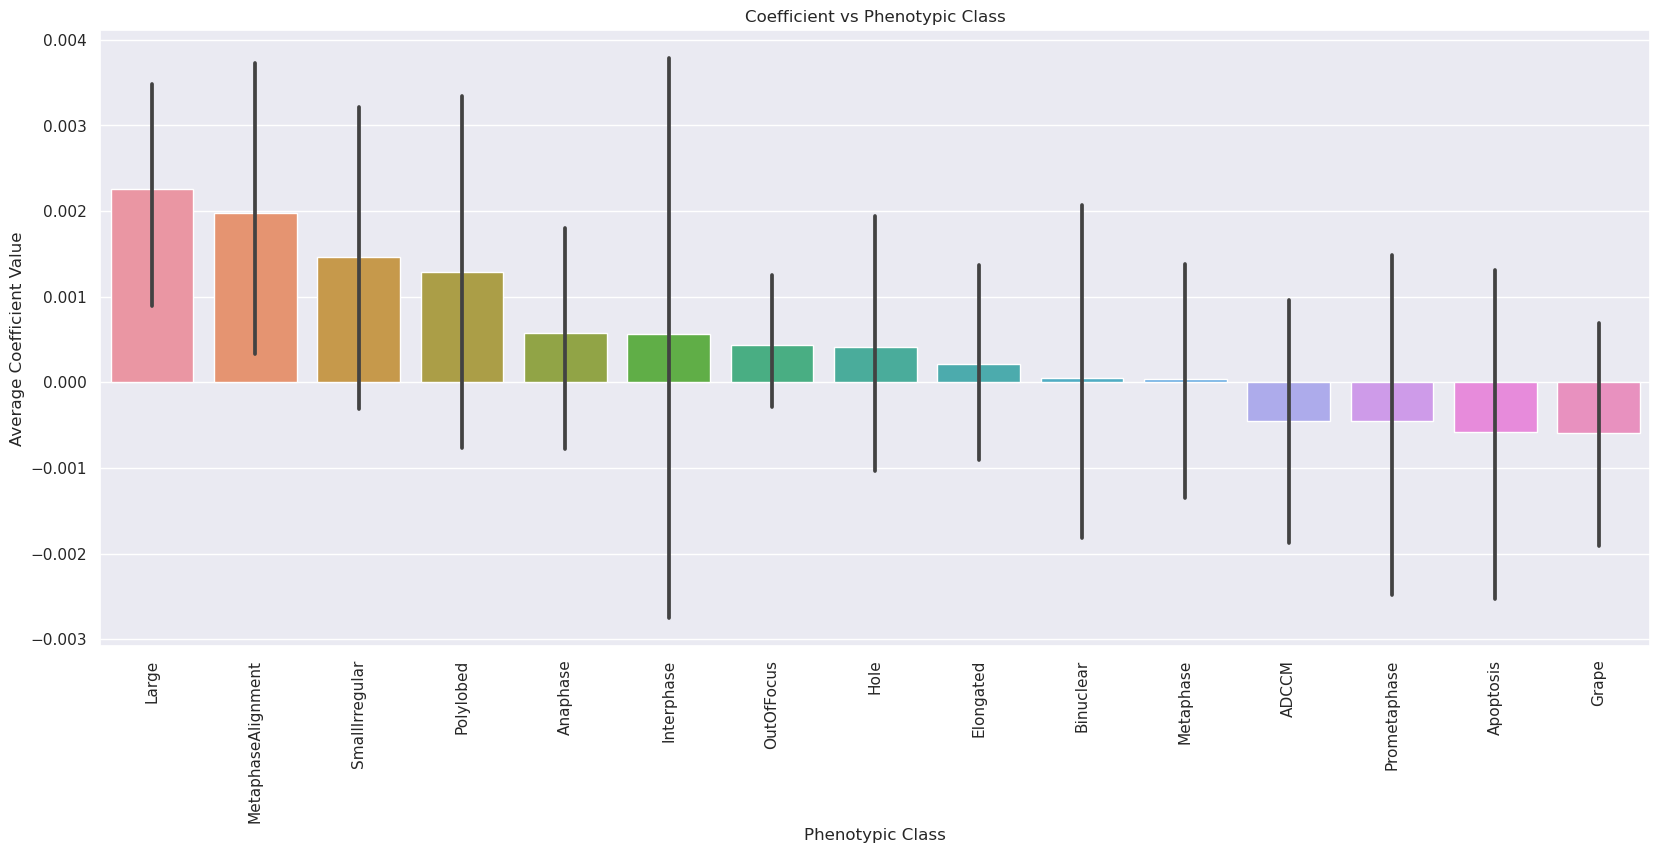

Interpreting model: shuffled_baseline 
Trained with features: CP
Shape of model coefficients(157, 15)


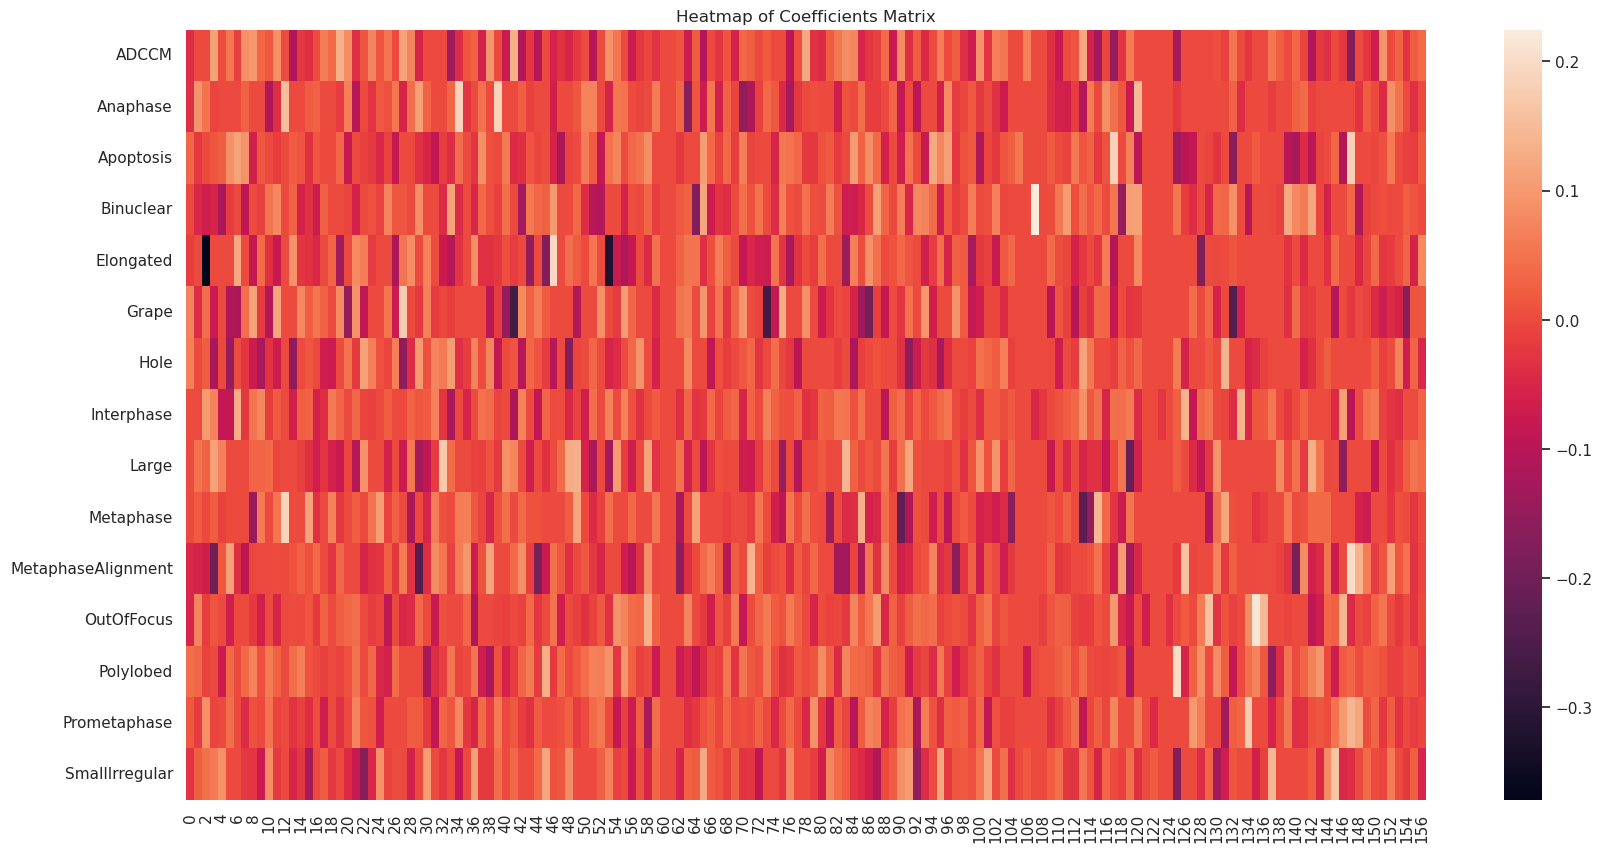

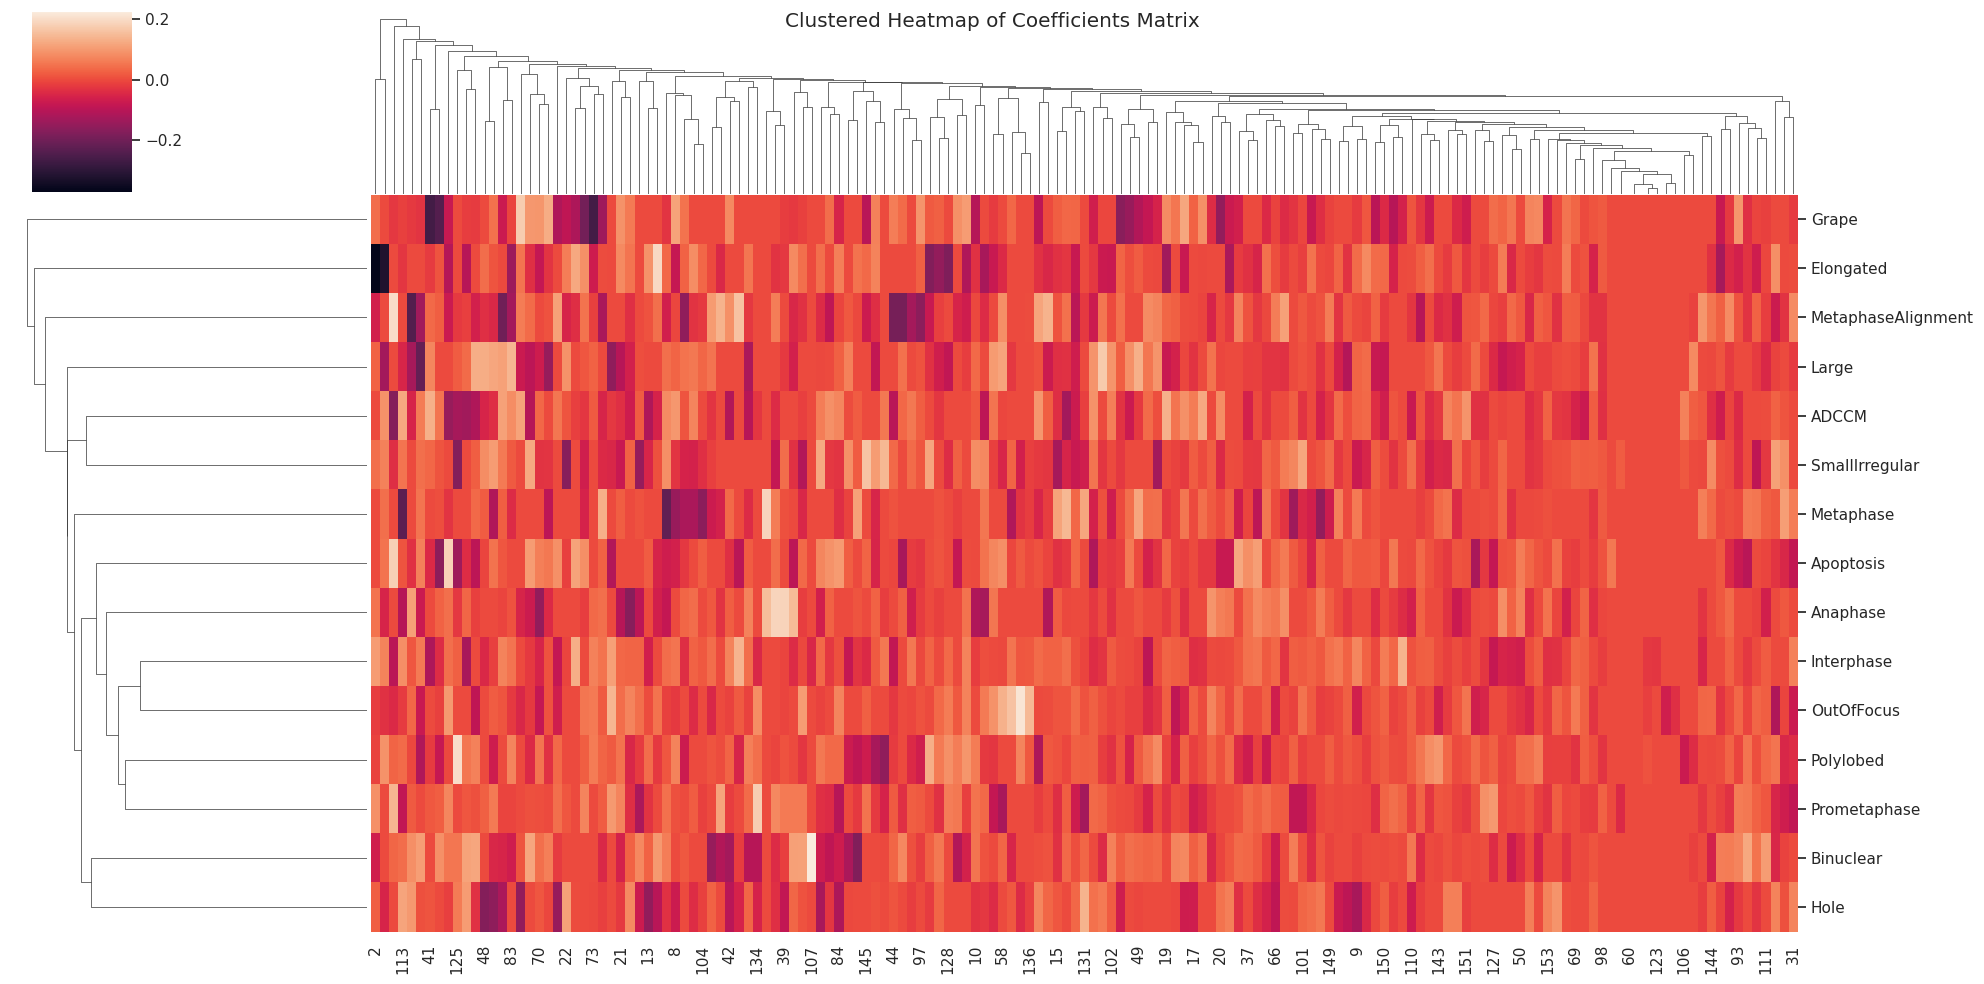

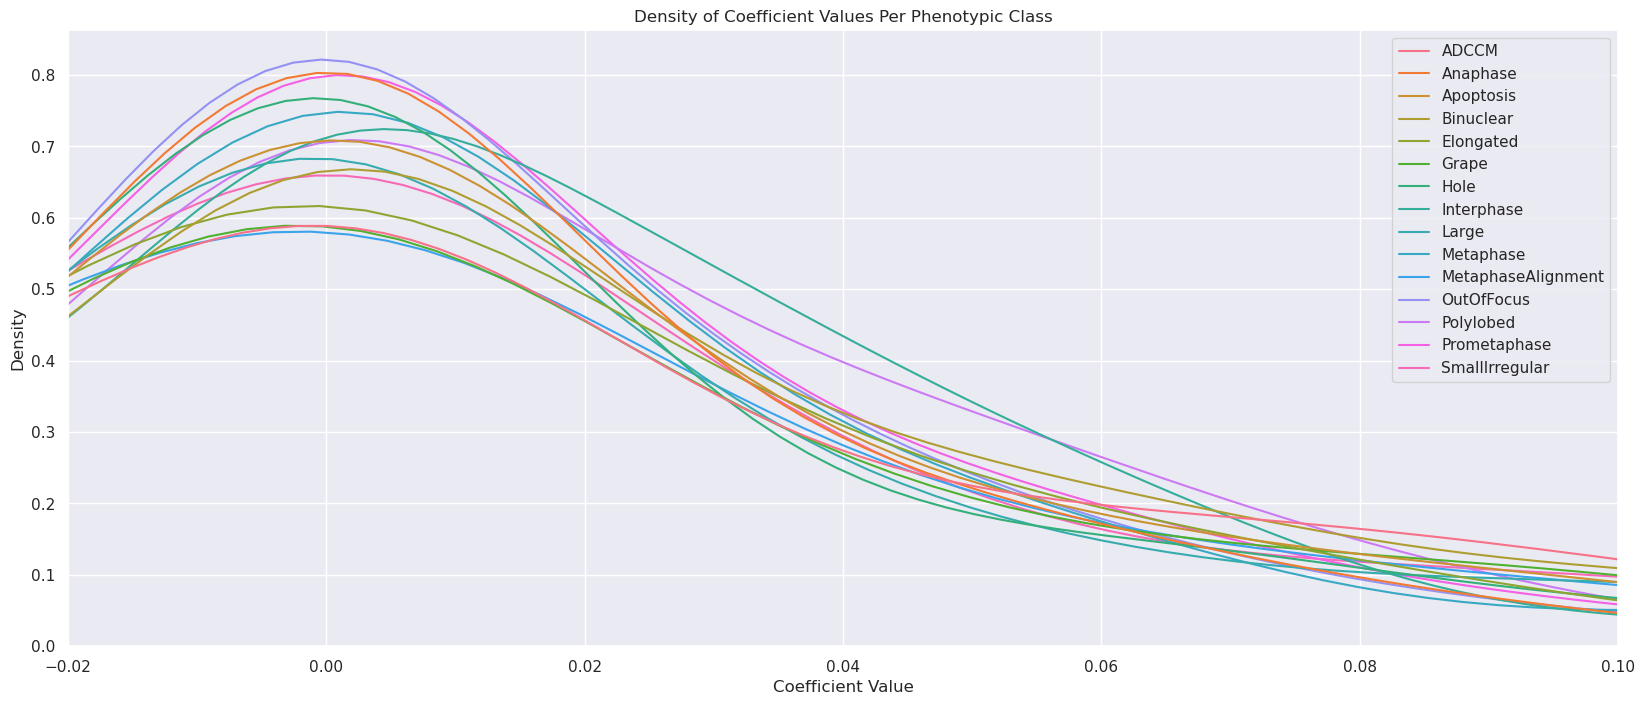

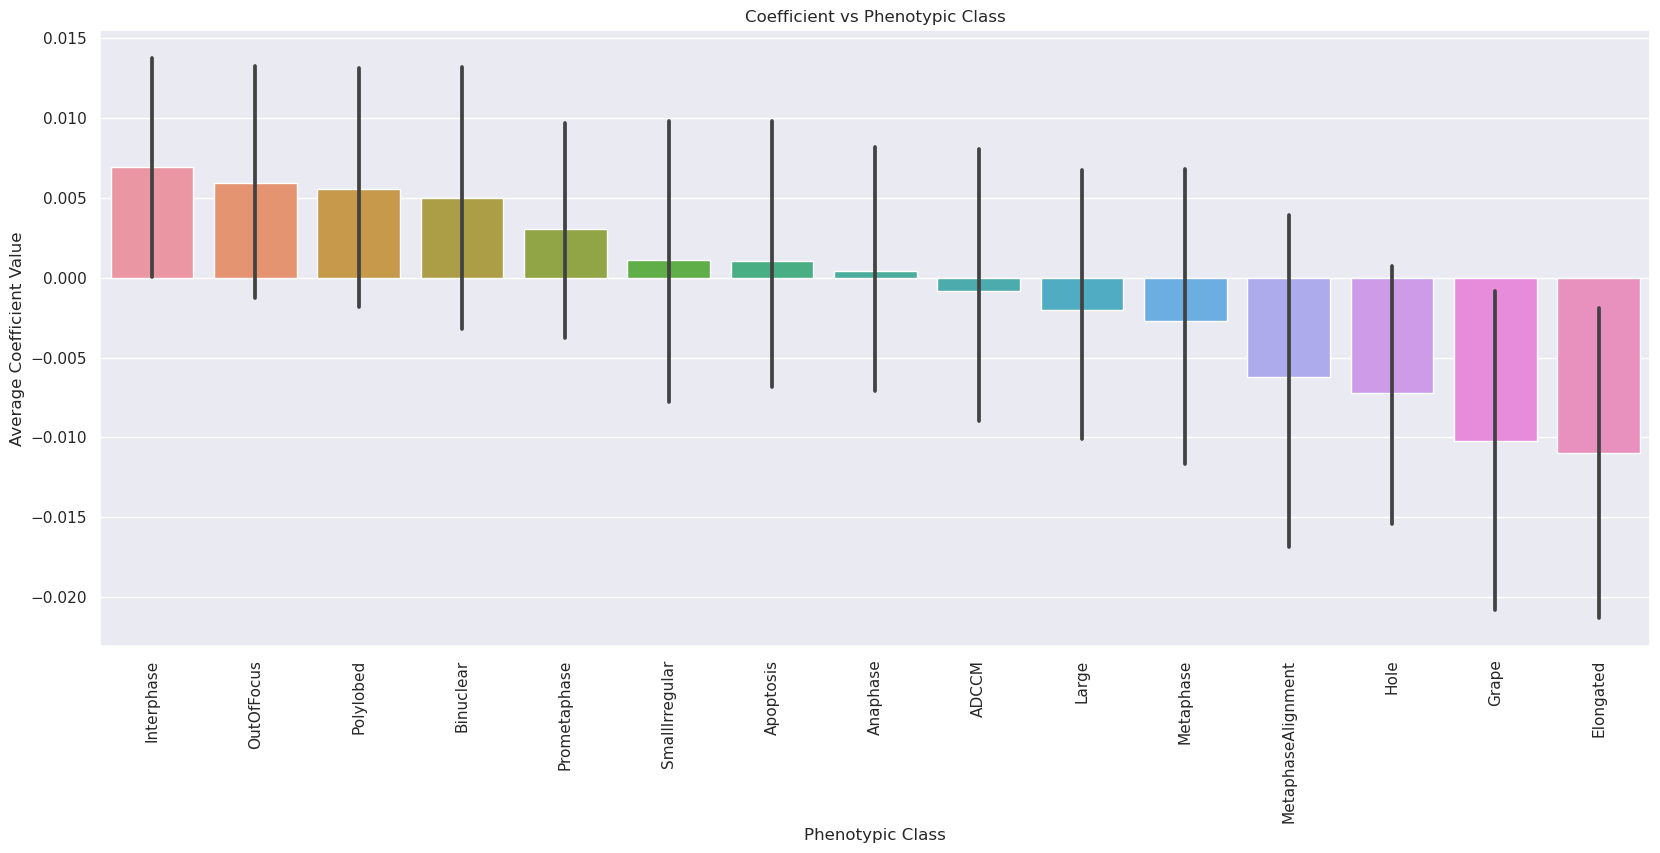

Interpreting model: shuffled_baseline 
Trained with features: CP_and_DP
Shape of model coefficients(1437, 15)


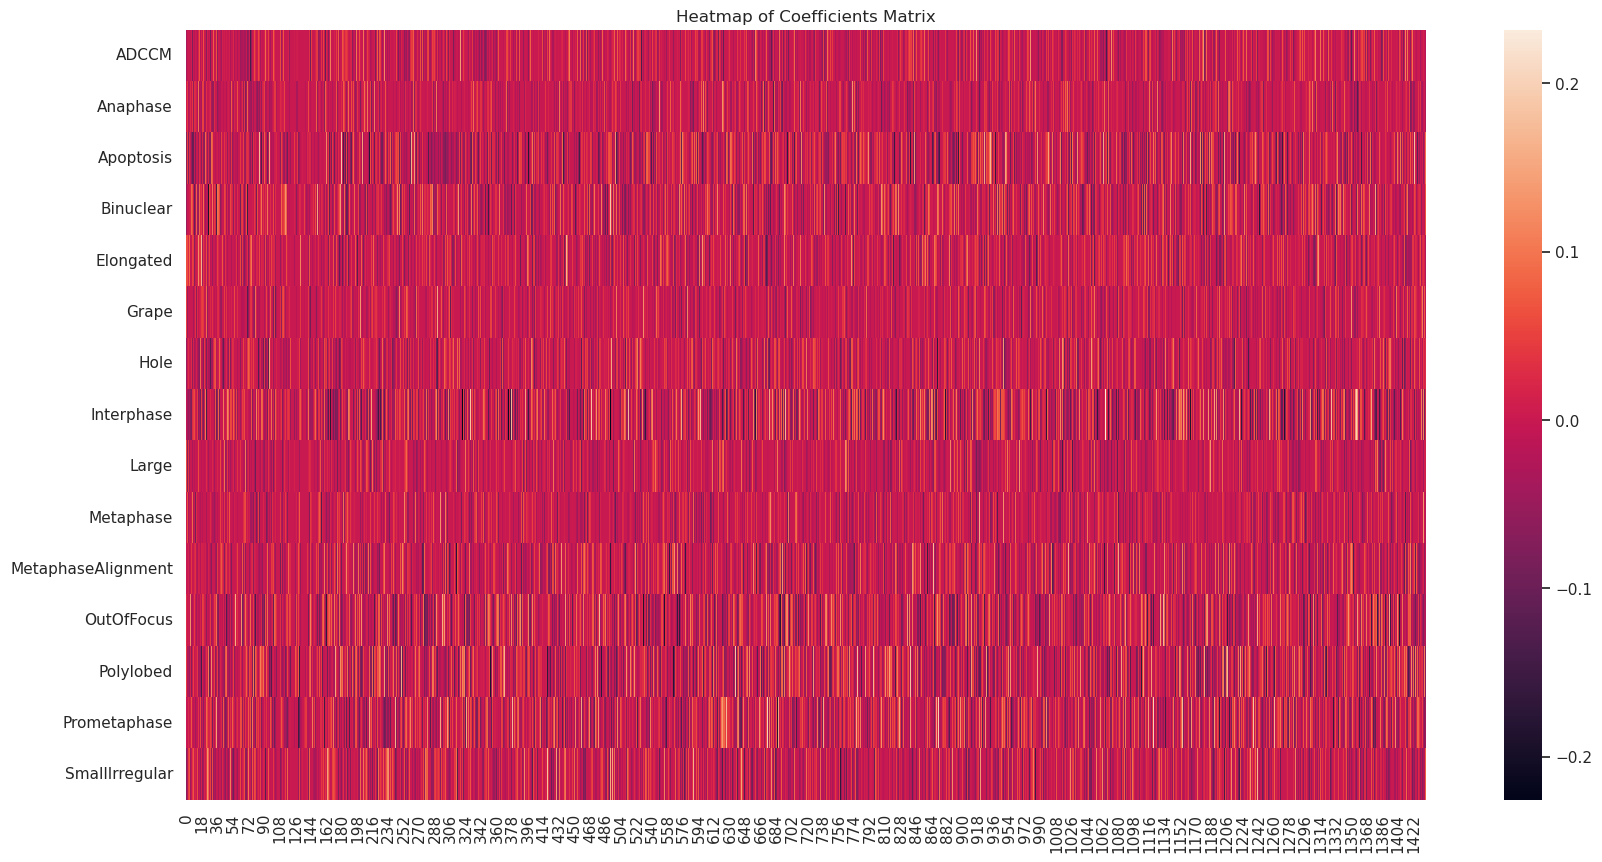

/home/roshankern/anaconda3/envs/phenotypic_profiling/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


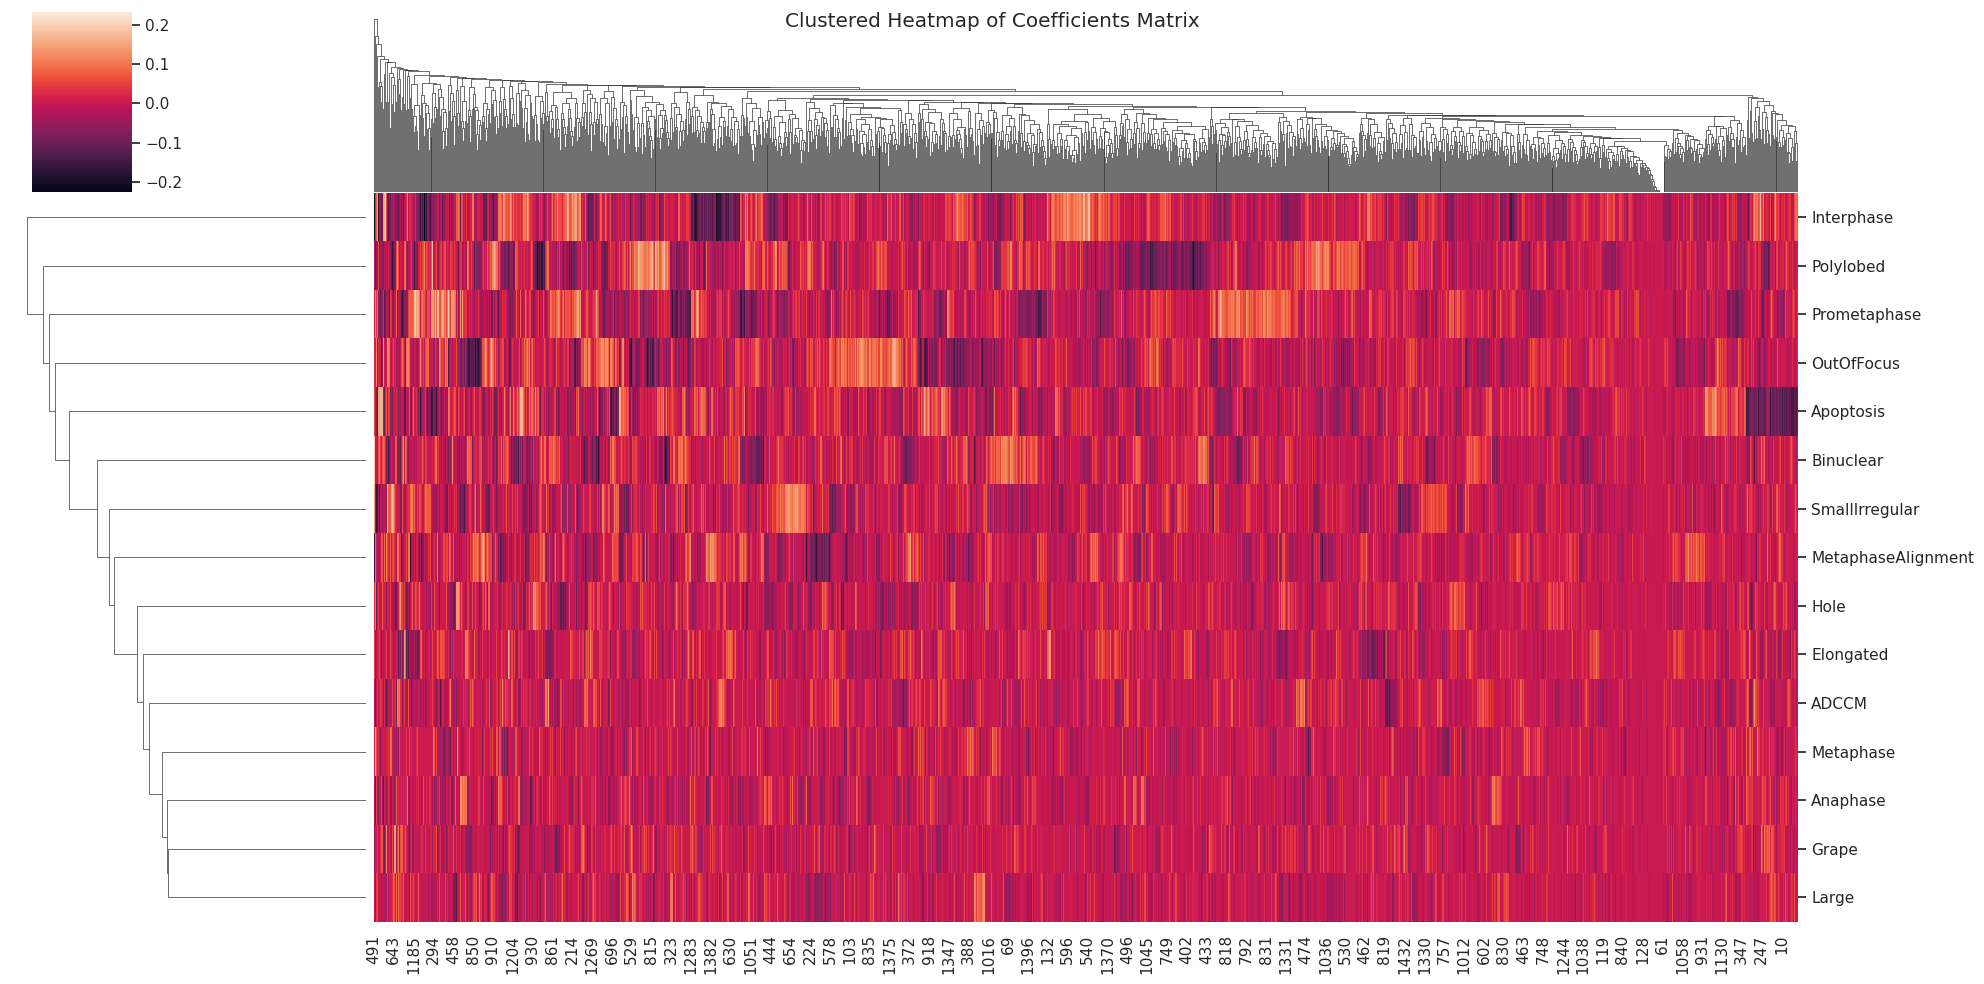

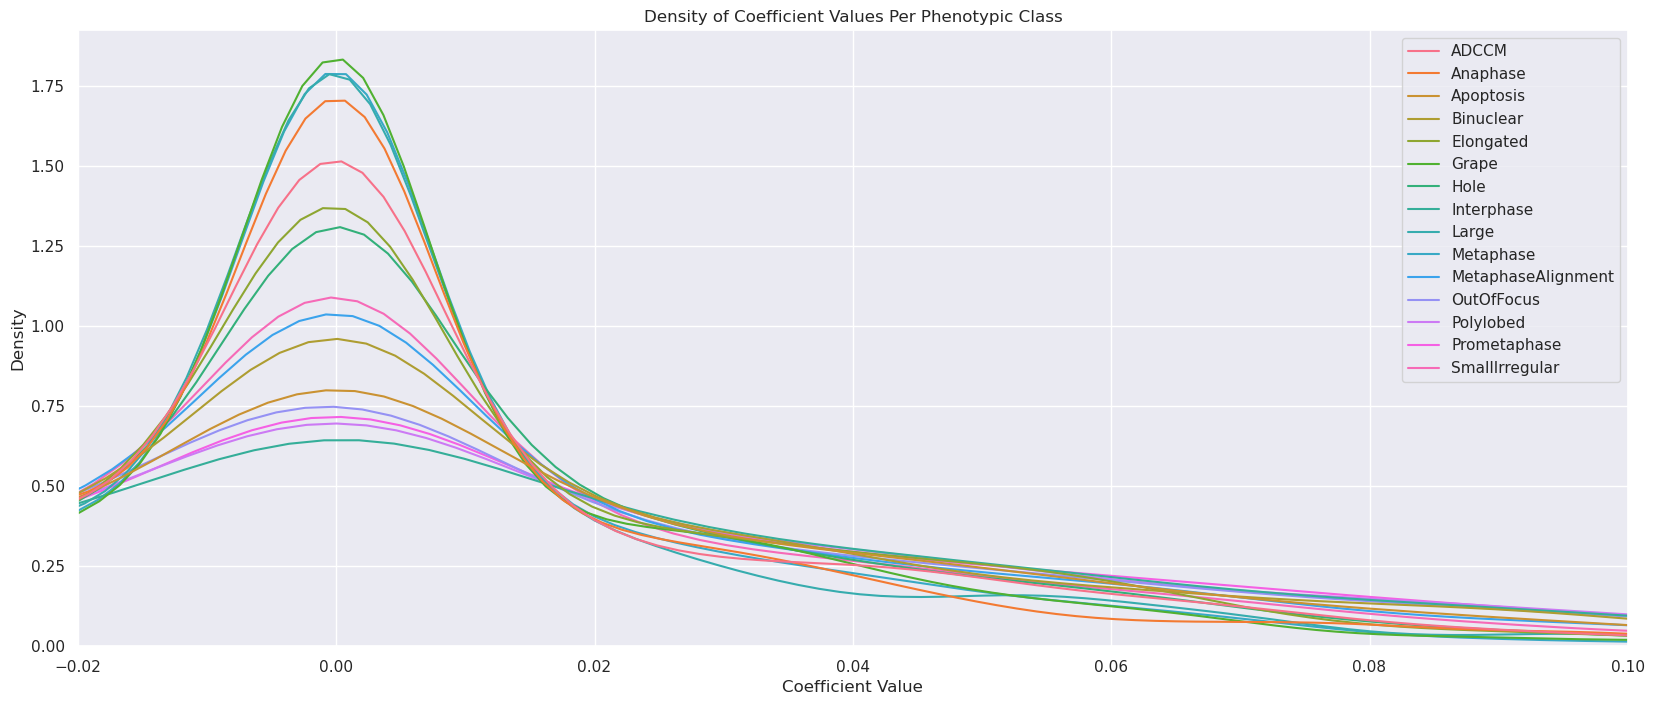

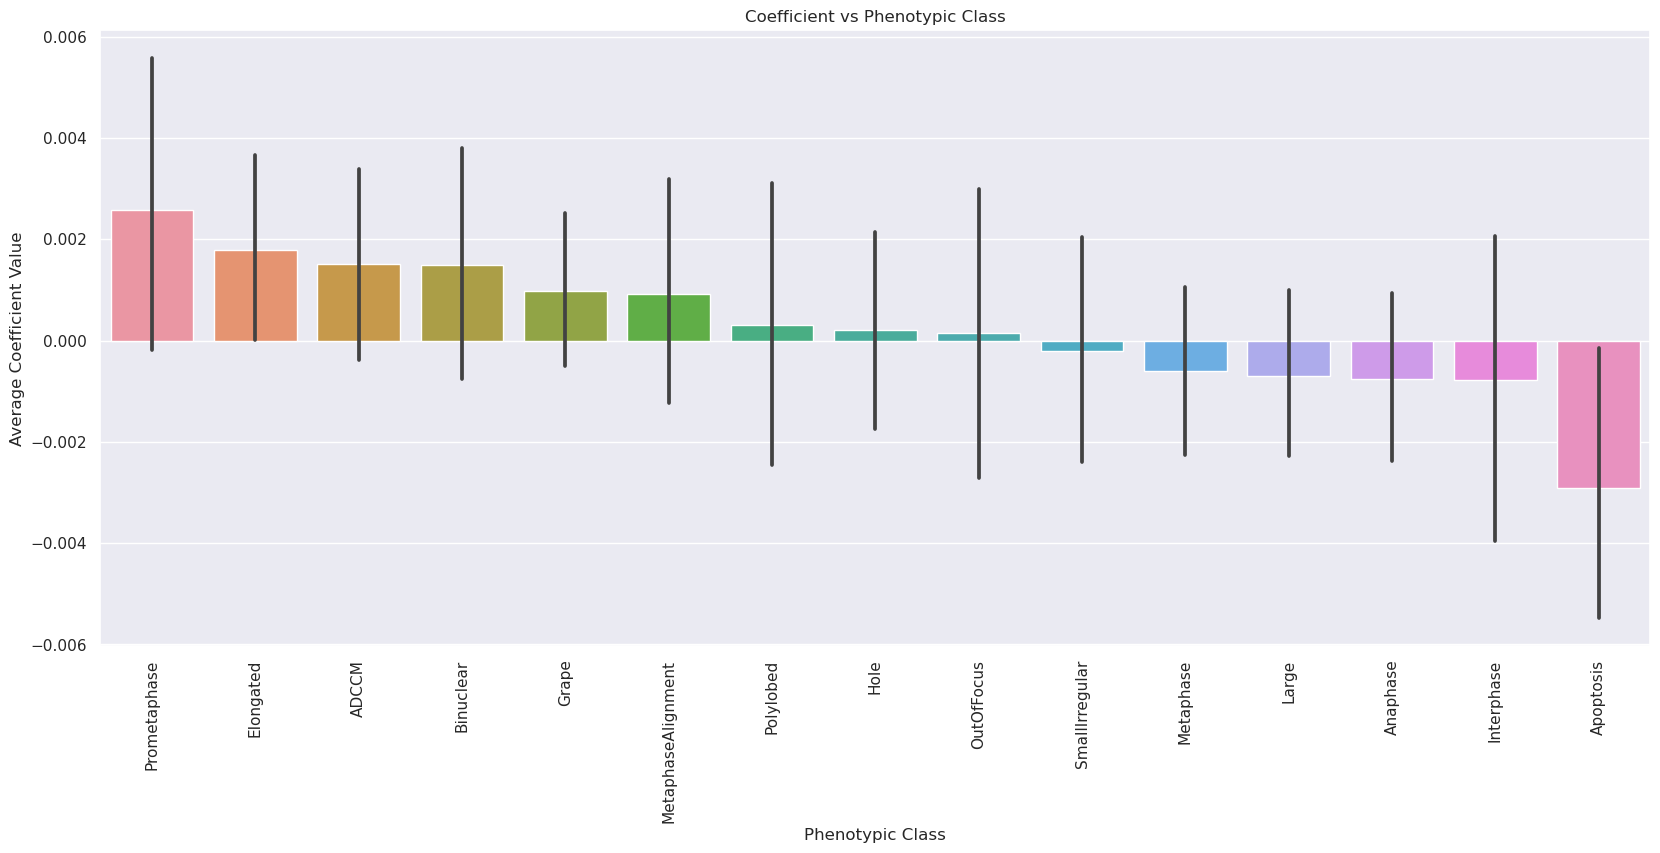

Interpreting model: shuffled_baseline 
Trained with features: DP
Shape of model coefficients(1280, 15)


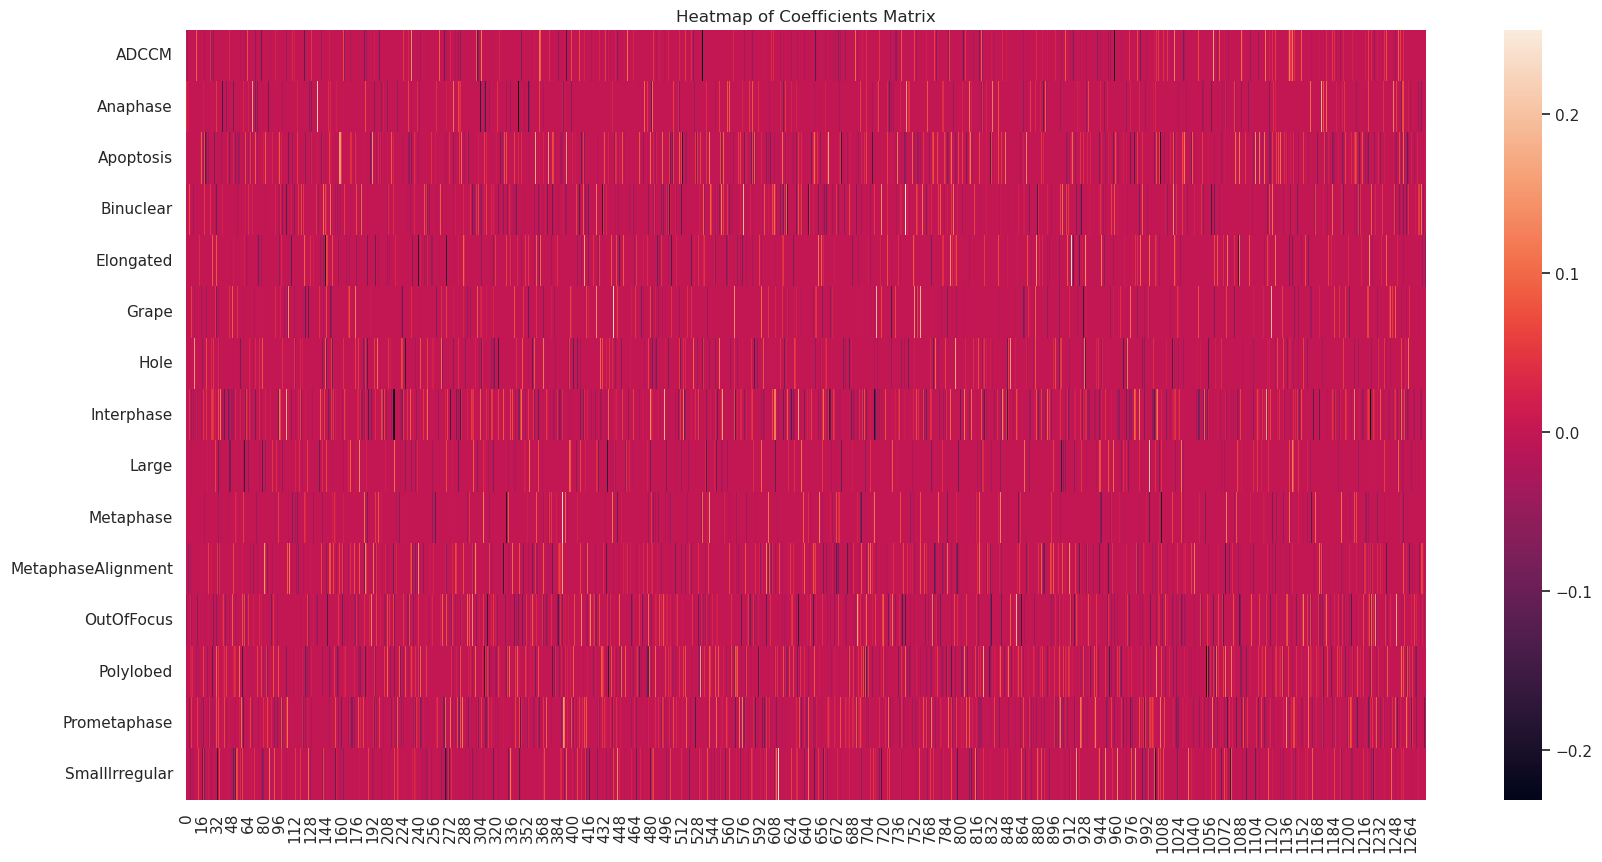

/home/roshankern/anaconda3/envs/phenotypic_profiling/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


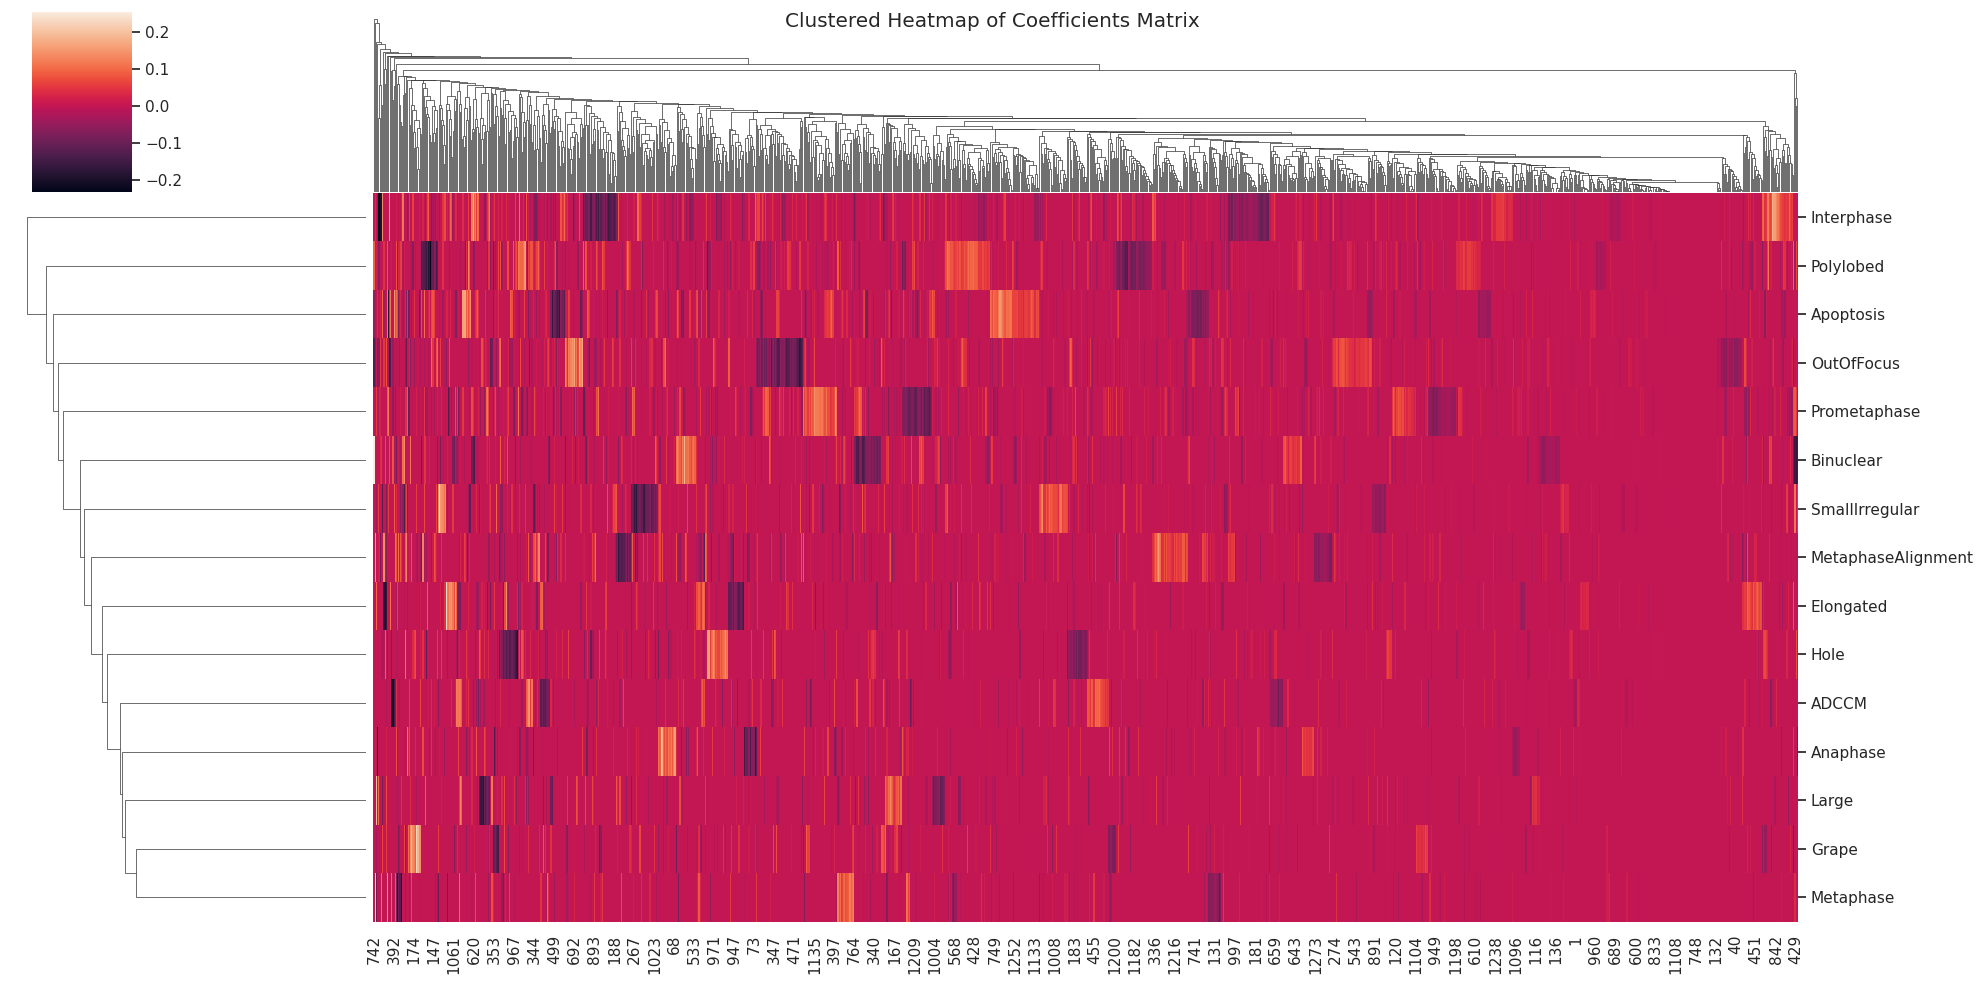

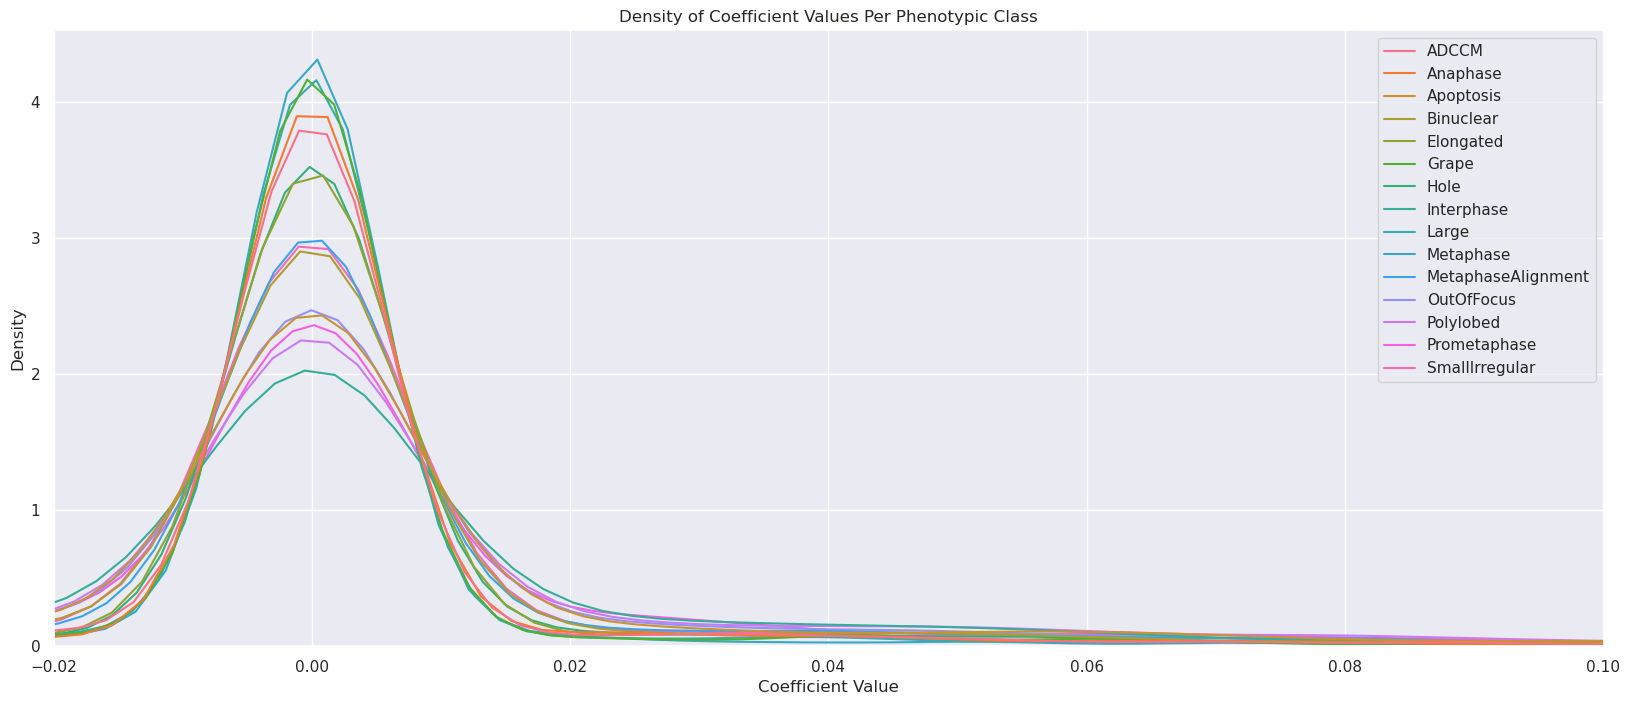

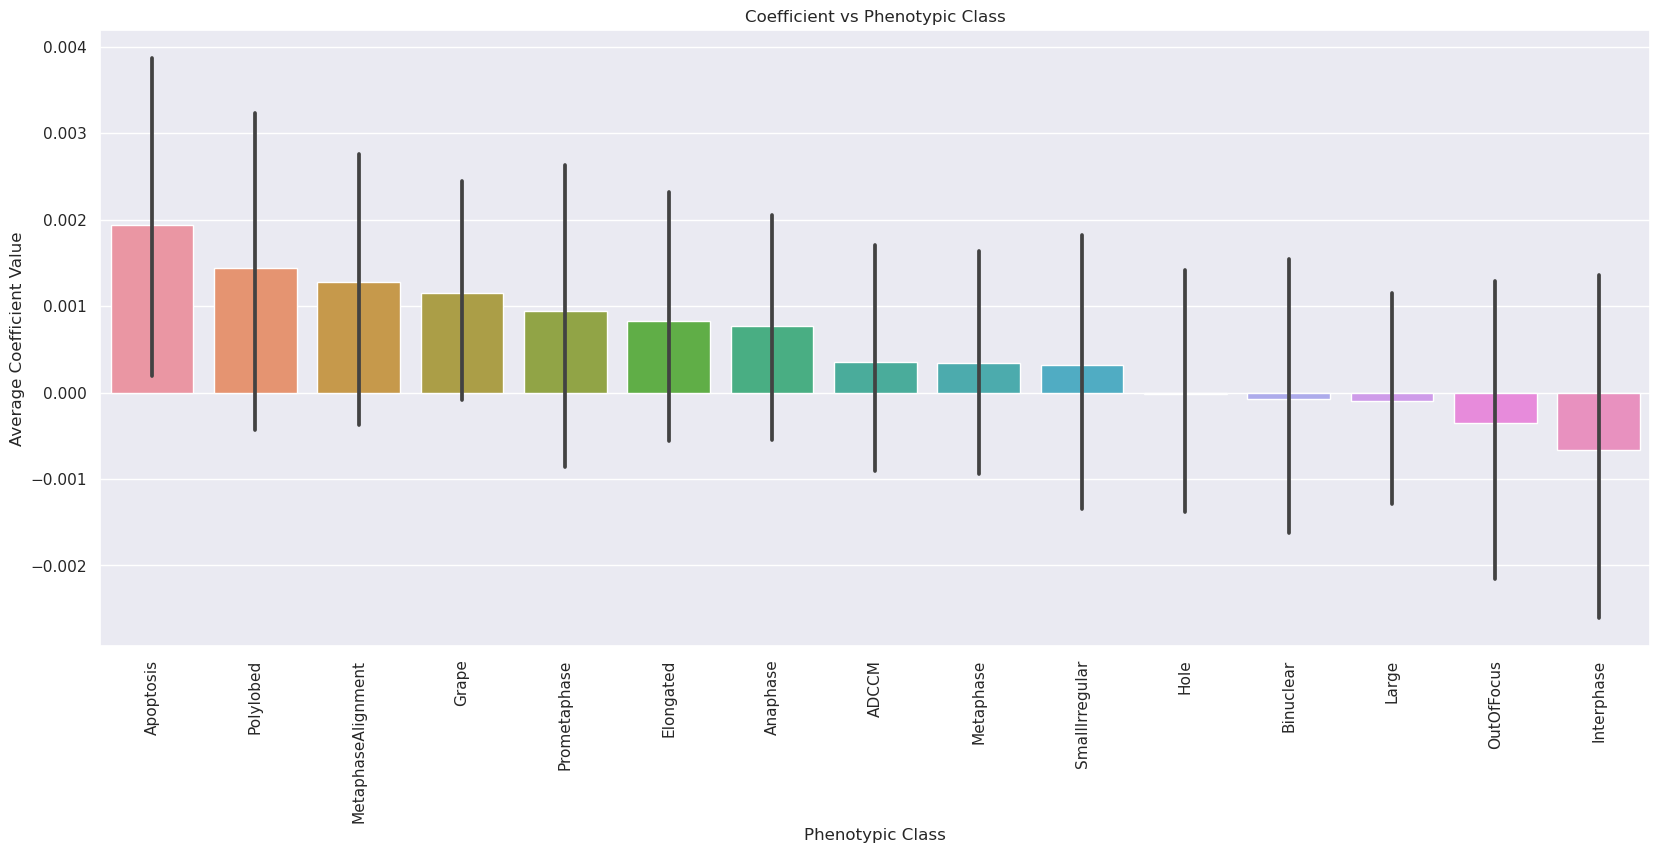

In [3]:
# directory to save models to
coefs_save_directory = pathlib.Path(f"coefficients/")
coefs_save_directory.mkdir(parents=True, exist_ok=True)

# directory to load the models from
models_dir = pathlib.Path("../2.train_model/models/multi_class_models")

# use a list to keep track of scores in tidy long format for each model and dataset combination
compiled_coefficients = []

# iterate through each model (final model, shuffled baseline model, etc)
# sorted so final models are shown before shuffled_baseline
for model_path in sorted(models_dir.iterdir()):
    # load model
    model = load(model_path)
    # determine model/feature type from model file name
    model_type = model_path.name.split("__")[0]
    feature_type = model_path.name.split("__")[1].replace(".joblib", "")

    print(f"Interpreting model: {model_type} \nTrained with features: {feature_type}")

    # get model coefficients and reshape them into a more useable format
    coefs = model.coef_
    coefs = pd.DataFrame(coefs).T
    coefs.columns = model.classes_
    print(f"Shape of model coefficients{coefs.shape}")

    # restructure/rename dataframe to tidy long format (see preview below)
    tidy_data = coefs.stack()
    tidy_data = pd.DataFrame(tidy_data).reset_index(level=[0, 1])
    tidy_data.columns = ["Feature_Name", "Phenotypic_Class", "Coefficent_Value"]
    tidy_data["shuffled"] = "shuffled" in model_type
    tidy_data["feature_type"] = feature_type

    # add feature names to coefficients dataframe
    # feature names depends on feature type
    all_cols = labeled_data.columns.tolist()
    # get DP,CP, or both features from all columns depending on desired dataset
    if feature_type == "CP":
        feature_cols = [col for col in all_cols if "CP__" in col]
    elif feature_type == "DP":
        feature_cols = [col for col in all_cols if "DP__" in col]
    elif feature_type == "CP_and_DP":
        feature_cols = [col for col in all_cols if "P__" in col]
    # add repeats to feature cols equal to the number of classes
    feature_names = [col for col in feature_cols for i in range(len(model.classes_))]
    tidy_data["Feature_Name"] = feature_names

    # add tidy data to the compilation list
    compiled_coefficients.append(tidy_data)

    # display heatmap of average coefs
    plt.figure(figsize=(20, 10))
    plt.title("Heatmap of Coefficients Matrix")
    ax = sns.heatmap(data=coefs.T)
    plt.show()

    # display clustered heatmap of coefficients
    ax = sns.clustermap(
        data=coefs.T, figsize=(20, 10), row_cluster=True, col_cluster=True
    )
    ax = ax.fig.suptitle("Clustered Heatmap of Coefficients Matrix")
    plt.show()

    # display density plot for coefficient values of each class
    sns.set(rc={"figure.figsize": (20, 8)})
    plt.xlim(-0.02, 0.1)
    plt.xlabel("Coefficient Value")
    plt.ylabel("Density")
    plt.title("Density of Coefficient Values Per Phenotypic Class")
    ax = sns.kdeplot(data=coefs)
    plt.show()

    # display average coefficient value vs phenotypic class bar chart
    pheno_class_ordered = coefs.reindex(
        coefs.mean().sort_values(ascending=False).index, axis=1
    )
    sns.set(rc={"figure.figsize": (20, 8)})
    plt.xlabel("Phenotypic Class")
    plt.ylabel("Average Coefficient Value")
    plt.title("Coefficient vs Phenotypic Class")
    plt.xticks(rotation=90)
    ax = sns.barplot(data=pheno_class_ordered)
    plt.show()


### Save multi class model coefficients


In [4]:
# compile list of tidy data into one dataframe
compiled_coefficients = pd.concat(compiled_coefficients).reset_index(drop=True)

# specify results directory
coefficients_dir = pathlib.Path("coefficients/")
coefficients_dir.mkdir(parents=True, exist_ok=True)

# define save path
compiled_coefficients_save_path = pathlib.Path(
    f"{coefficients_dir}/compiled_coefficients.tsv"
)

# save data as tsv
compiled_coefficients.to_csv(compiled_coefficients_save_path, sep="\t")

# preview tidy data
compiled_coefficients

,Feature_Name,Phenotypic_Class,Coefficent_Value,shuffled,feature_type
0,CP__AreaShape_Area,ADCCM,0.008227,False,CP
1,CP__AreaShape_Area,Anaphase,-0.018625,False,CP
2,CP__AreaShape_Area,Apoptosis,-0.021025,False,CP
3,CP__AreaShape_Area,Binuclear,0.029871,False,CP
4,CP__AreaShape_Area,Elongated,-0.043384,False,CP
...,...,...,...,...,...
86215,DP__efficientnet_1279,MetaphaseAlignment,0.000000,True,DP
86216,DP__efficientnet_1279,OutOfFocus,0.020468,True,DP
86217,DP__efficientnet_1279,Polylobed,0.000000,True,DP
86218,DP__efficientnet_1279,Prometaphase,0.000000,True,DP
